In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from kagglehub import dataset_download
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error



# Load dataset from Kaggle
path = dataset_download("toramky/automobile-dataset")
csv = os.listdir(path)[0]
df = pd.read_csv(os.path.join(path, csv))
target_column = 'price'  # Replace with the name of your target column

# Data preprocessing
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df = df.drop(columns=[
    'make', 'fuel-type', 'aspiration', 'num-of-doors', 
    'body-style', 'drive-wheels', 'fuel-system', 
    'engine-location', 'engine-type', 'num-of-cylinders'
])
df = df.astype(float)  # Convert all columns to numeric

# Split data into training and testing sets
X = df.drop(columns=[target_column])
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define transformations
def standardize(column):
    scaler = StandardScaler()
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

def normalize(column):
    scaler = MinMaxScaler()
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

def log_transform(column):
    # Ensure all values are positive and non-zero for log transformation
    return np.log1p(np.clip(column, a_min=1e-5, a_max=None))

def polynomial_features(column, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    return poly.fit_transform(column.values.reshape(-1, 1)).flatten()




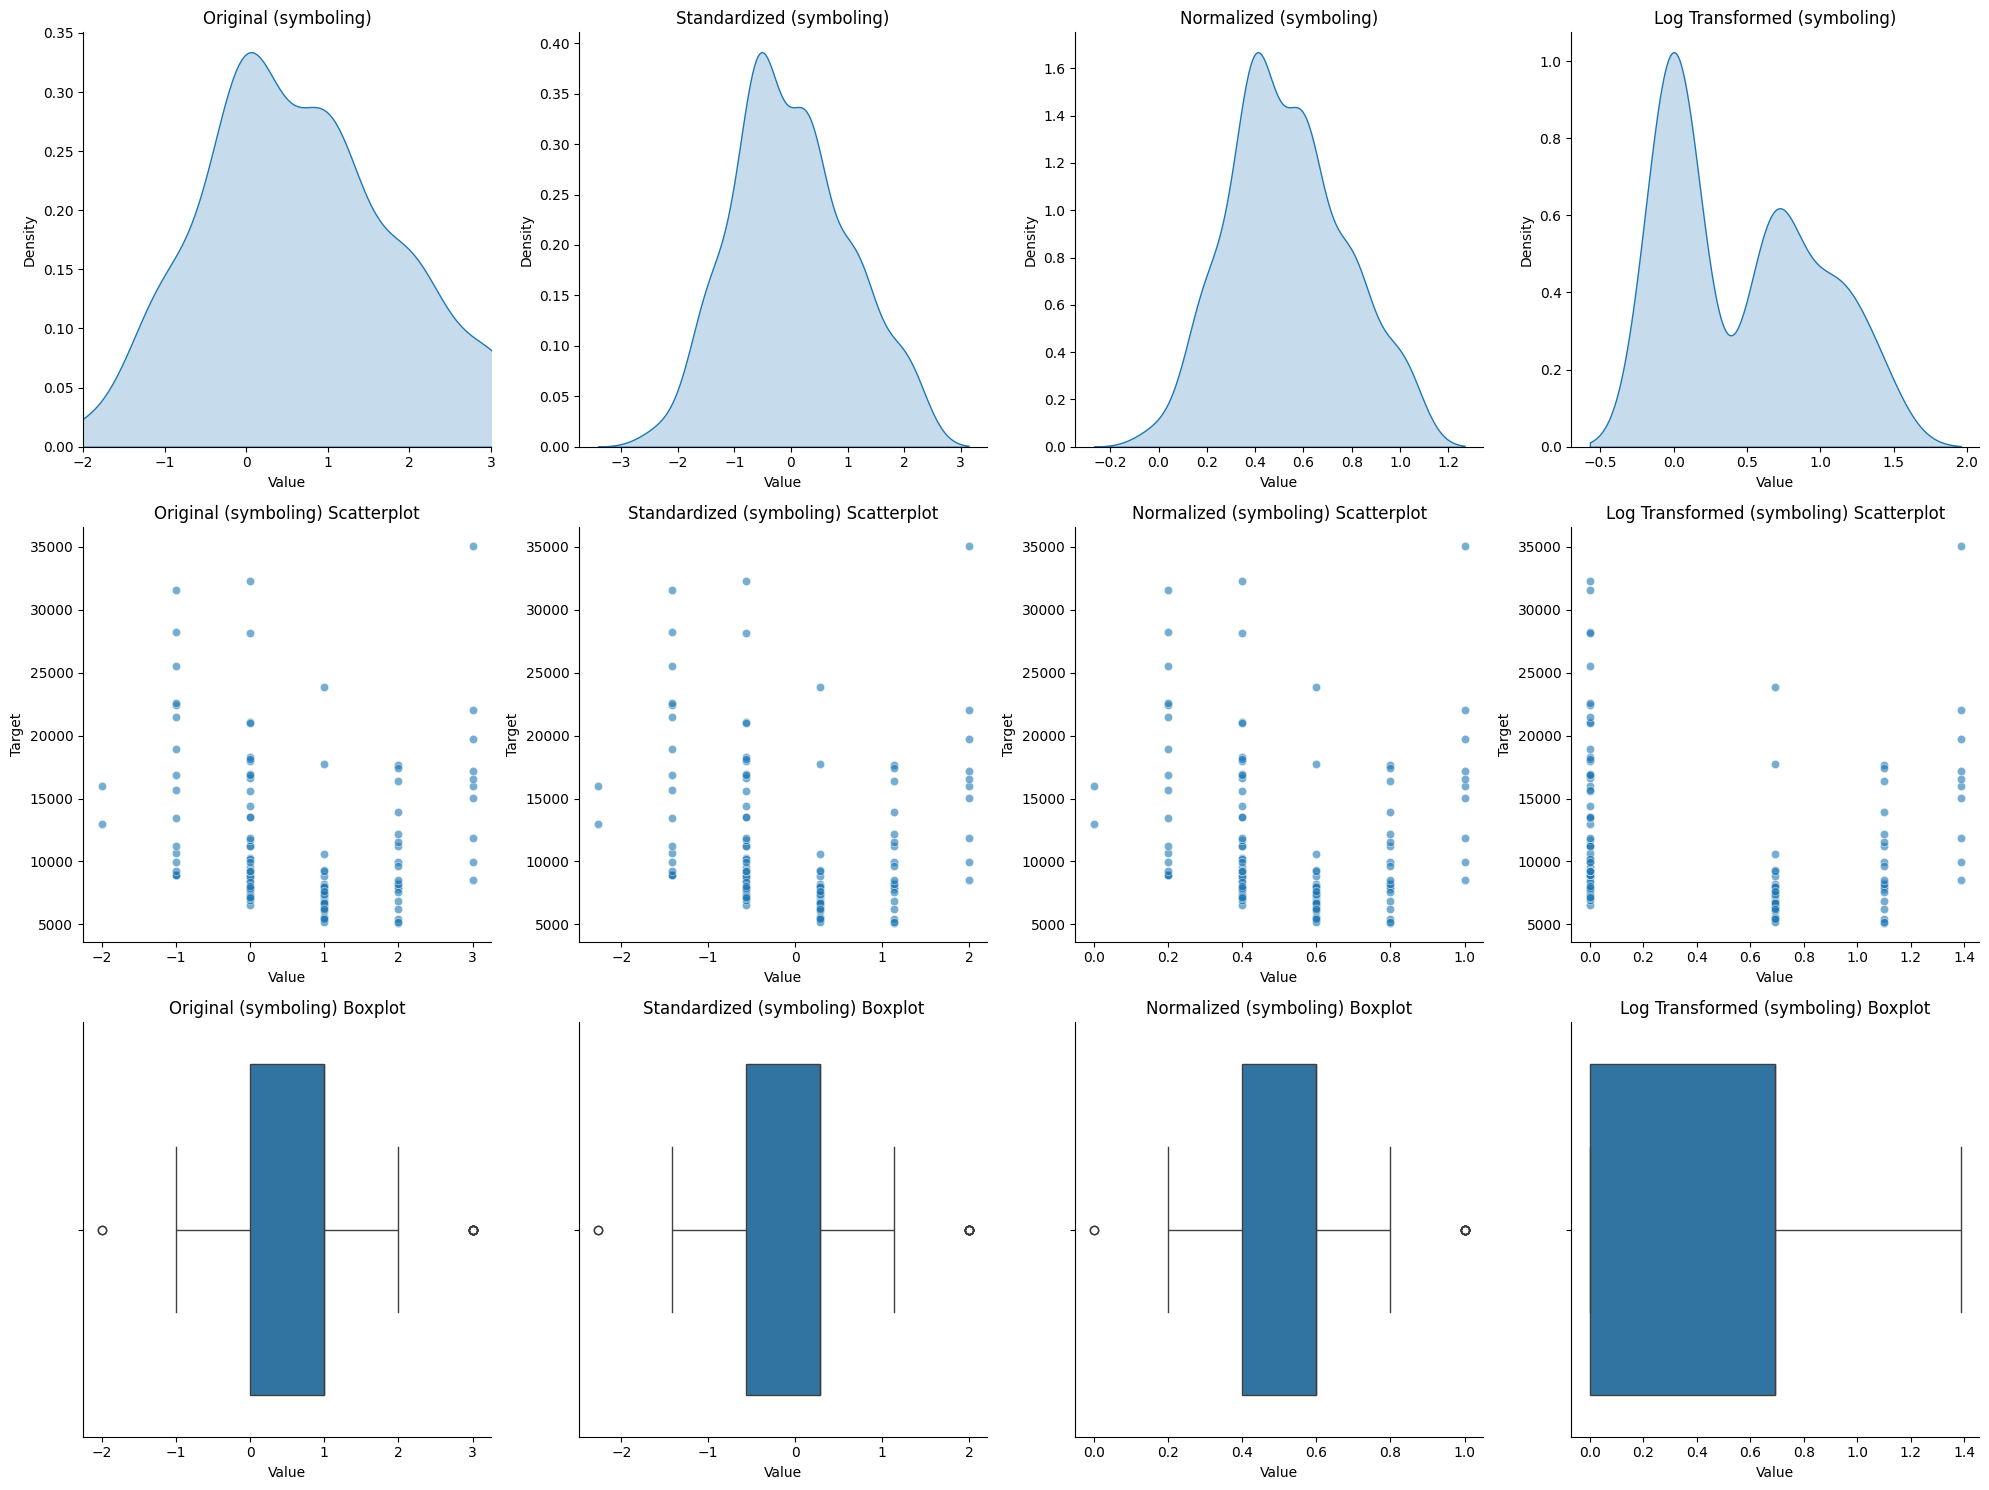

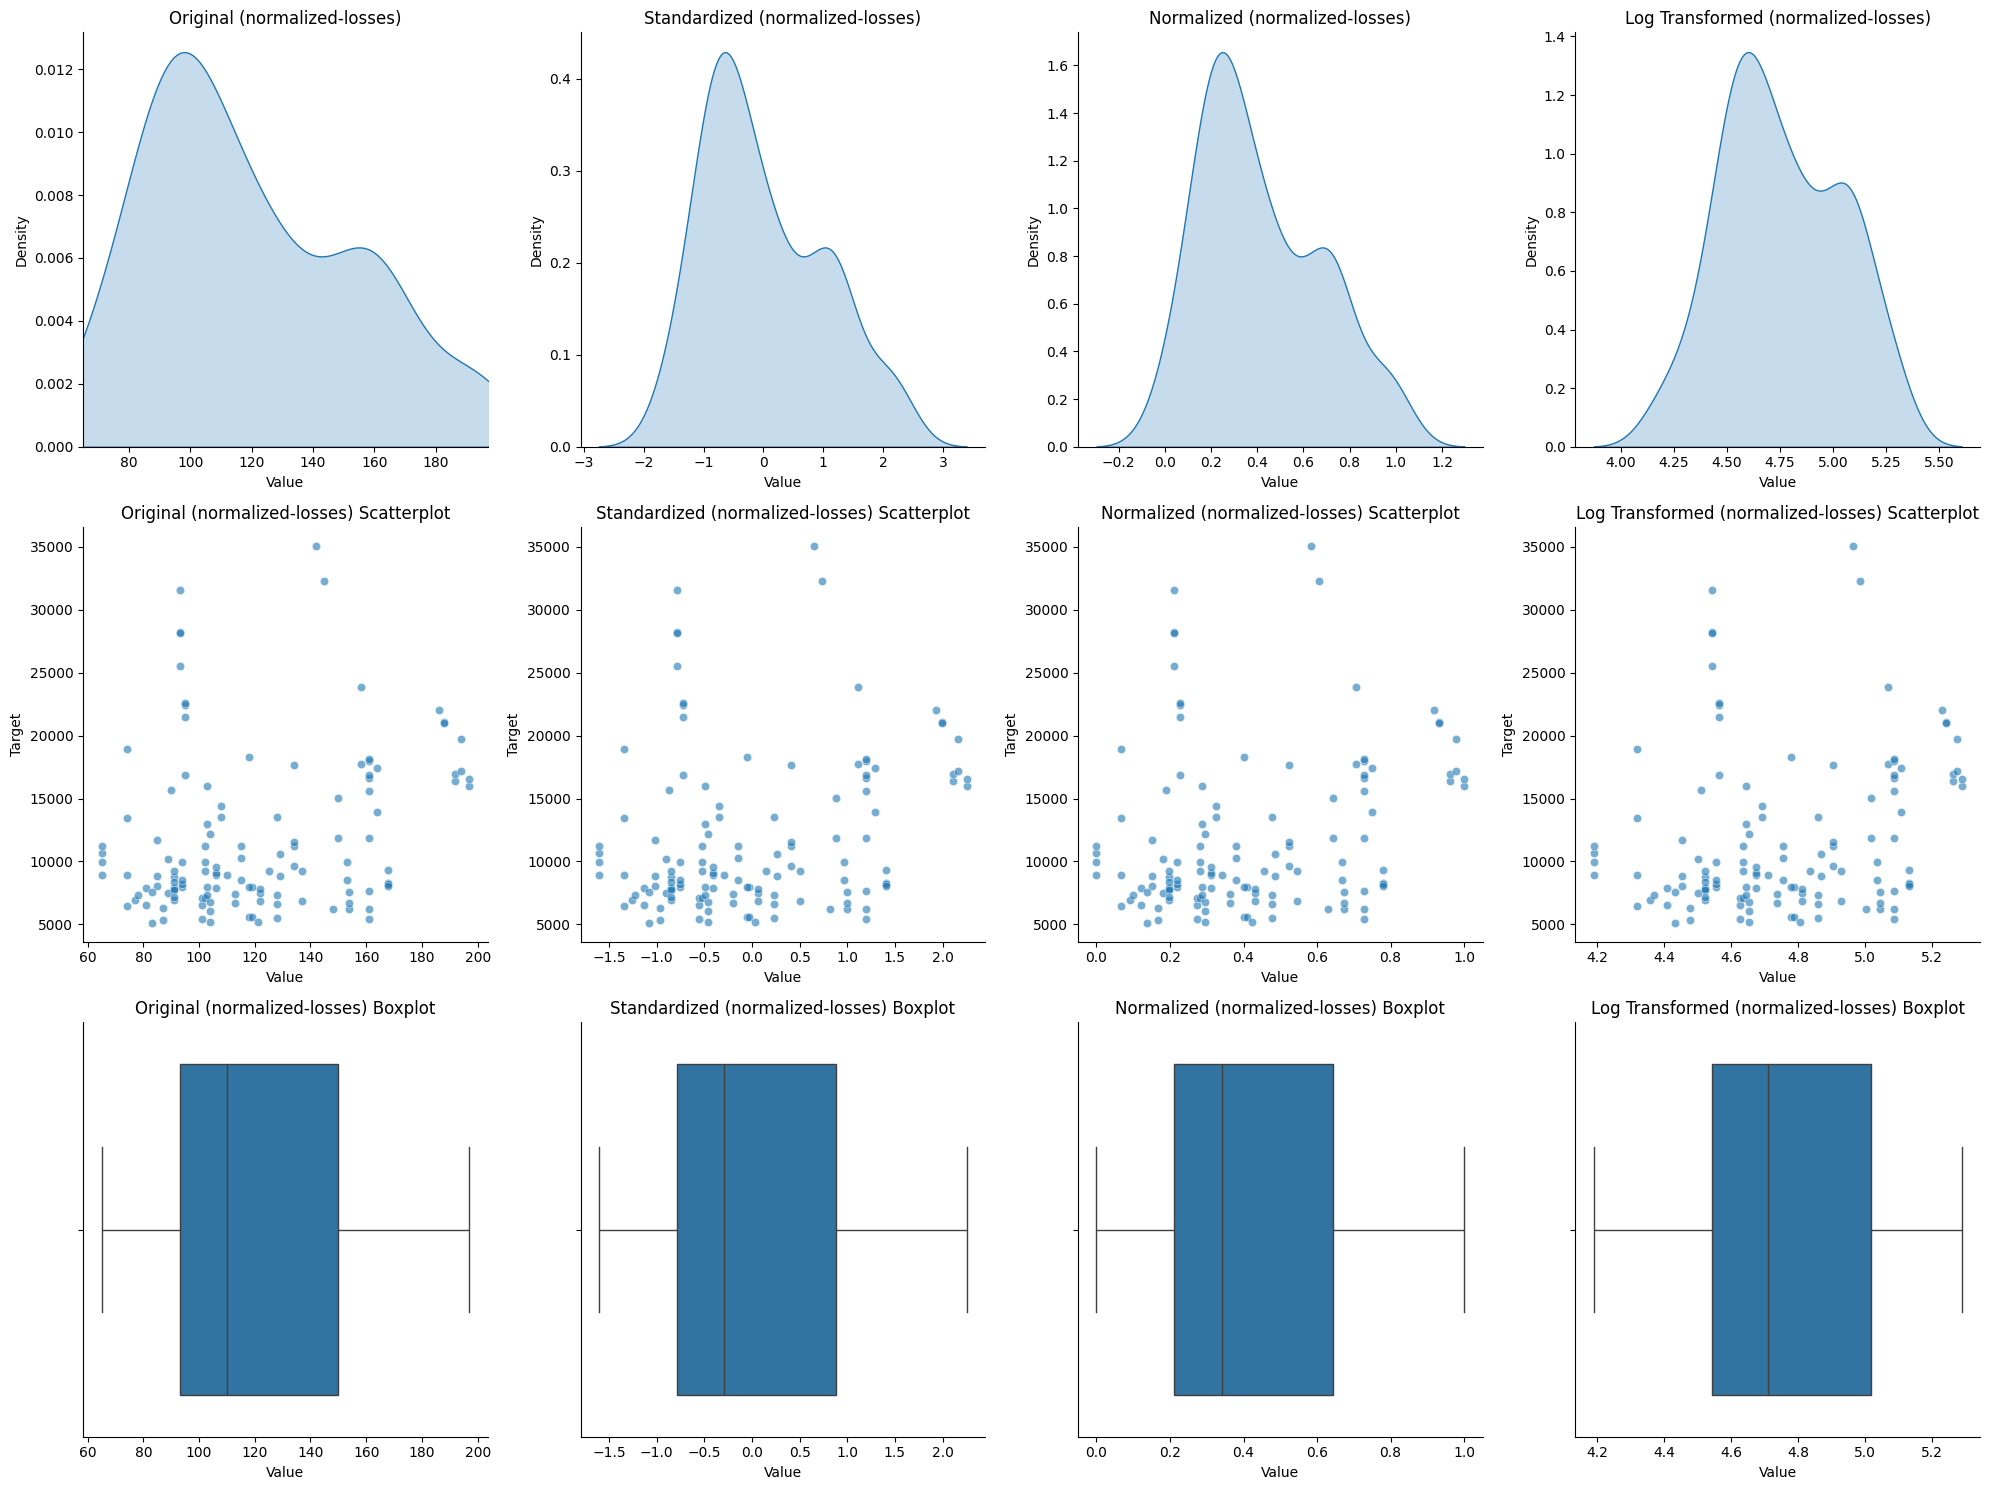

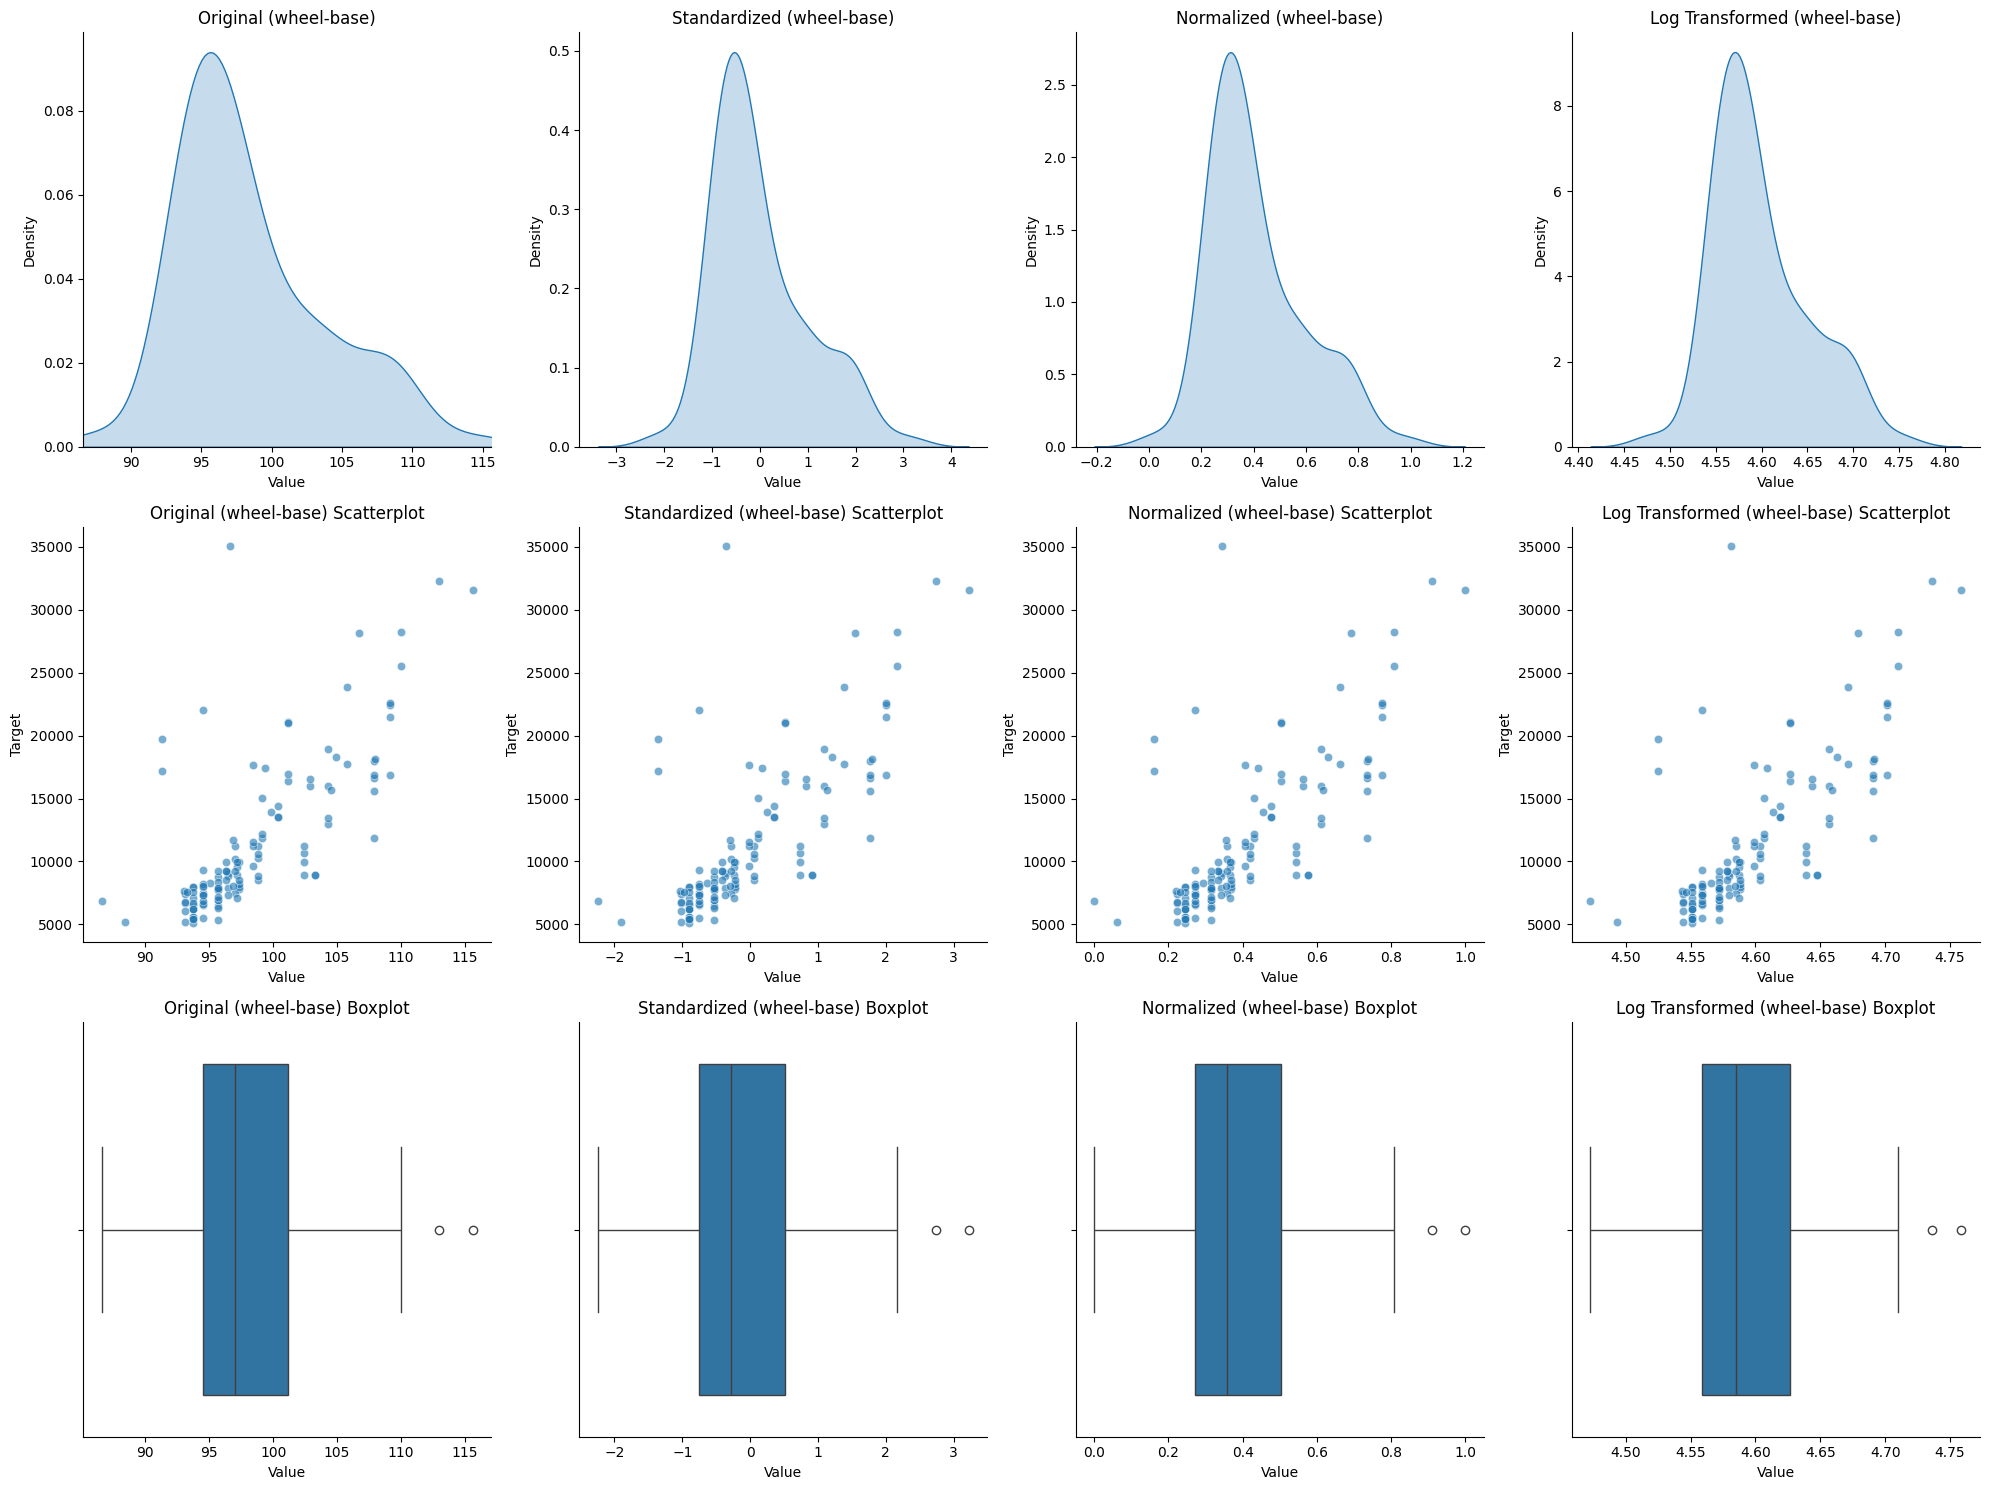

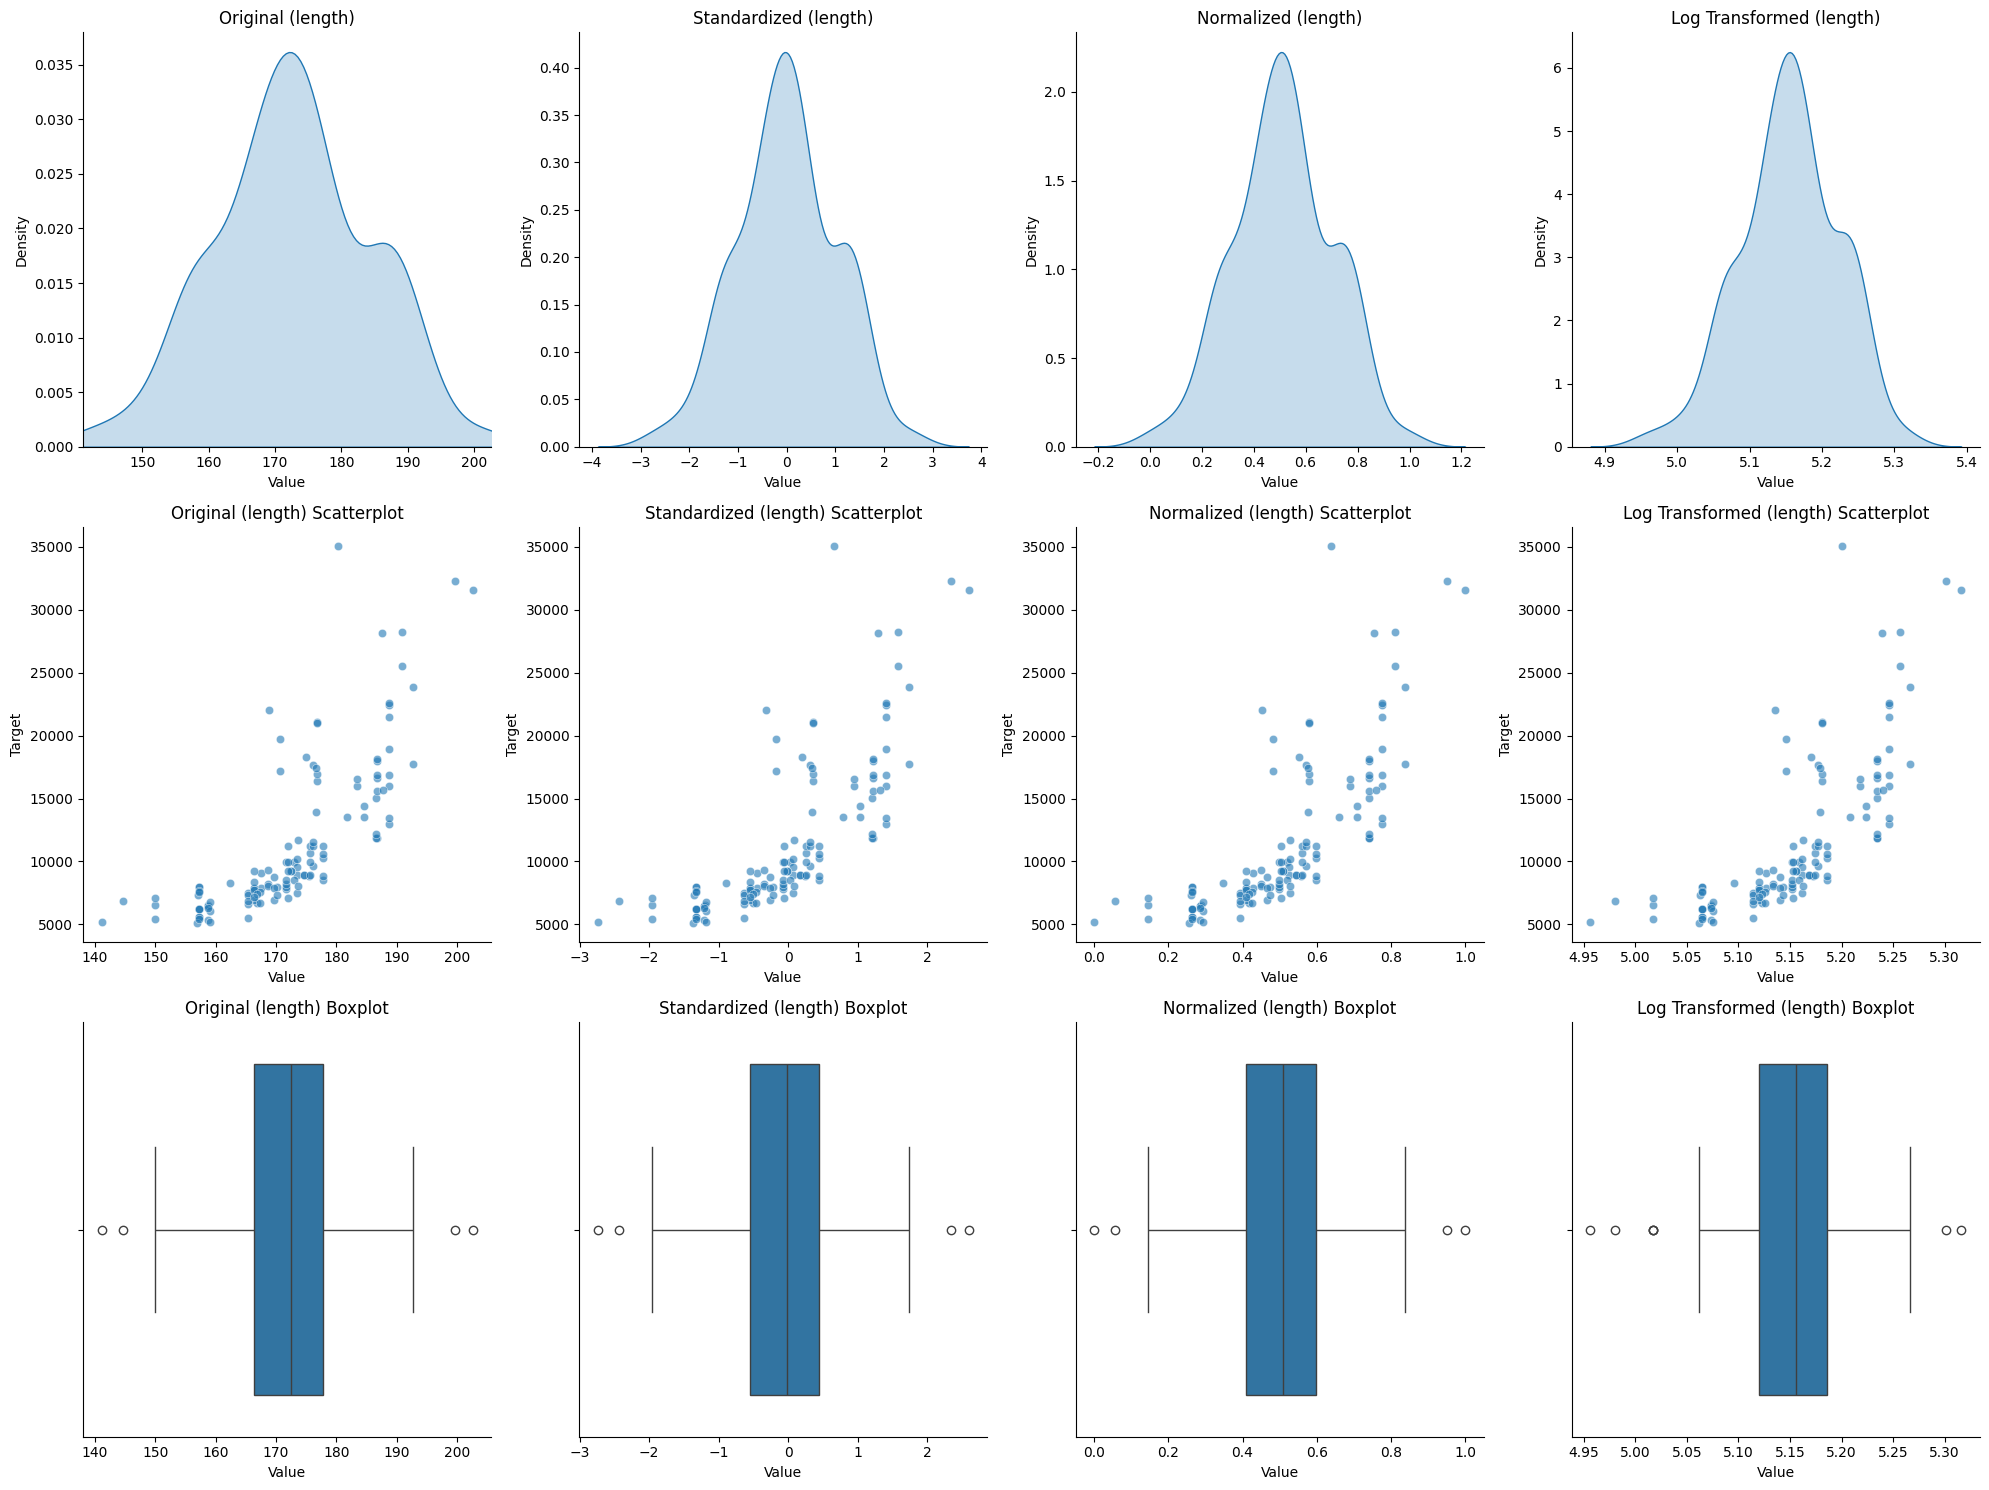

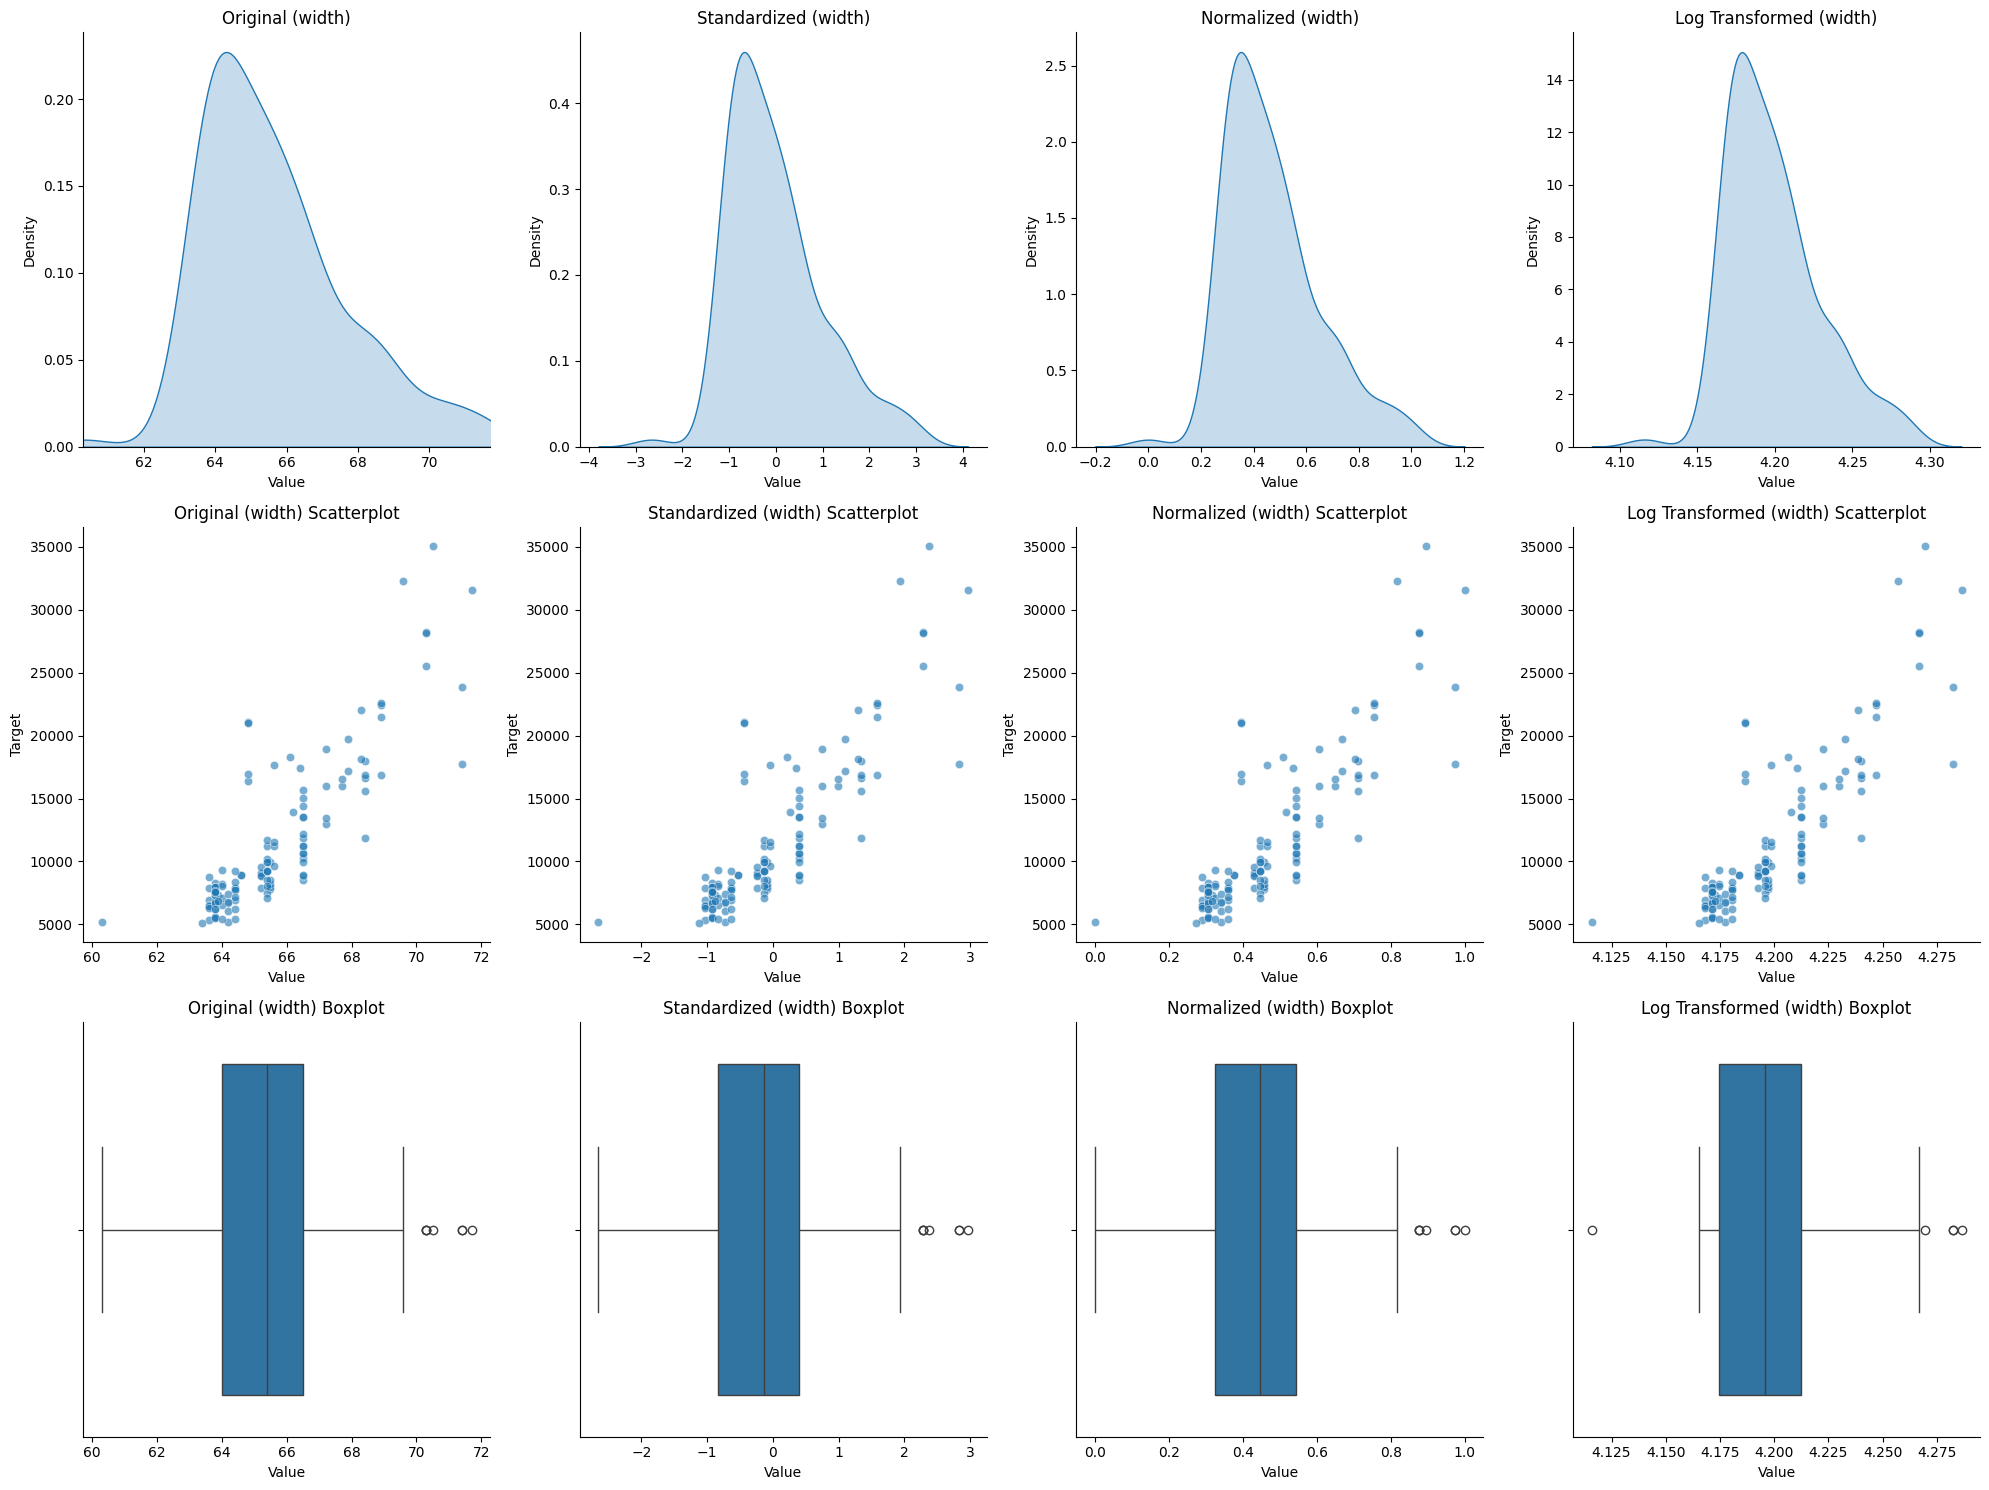

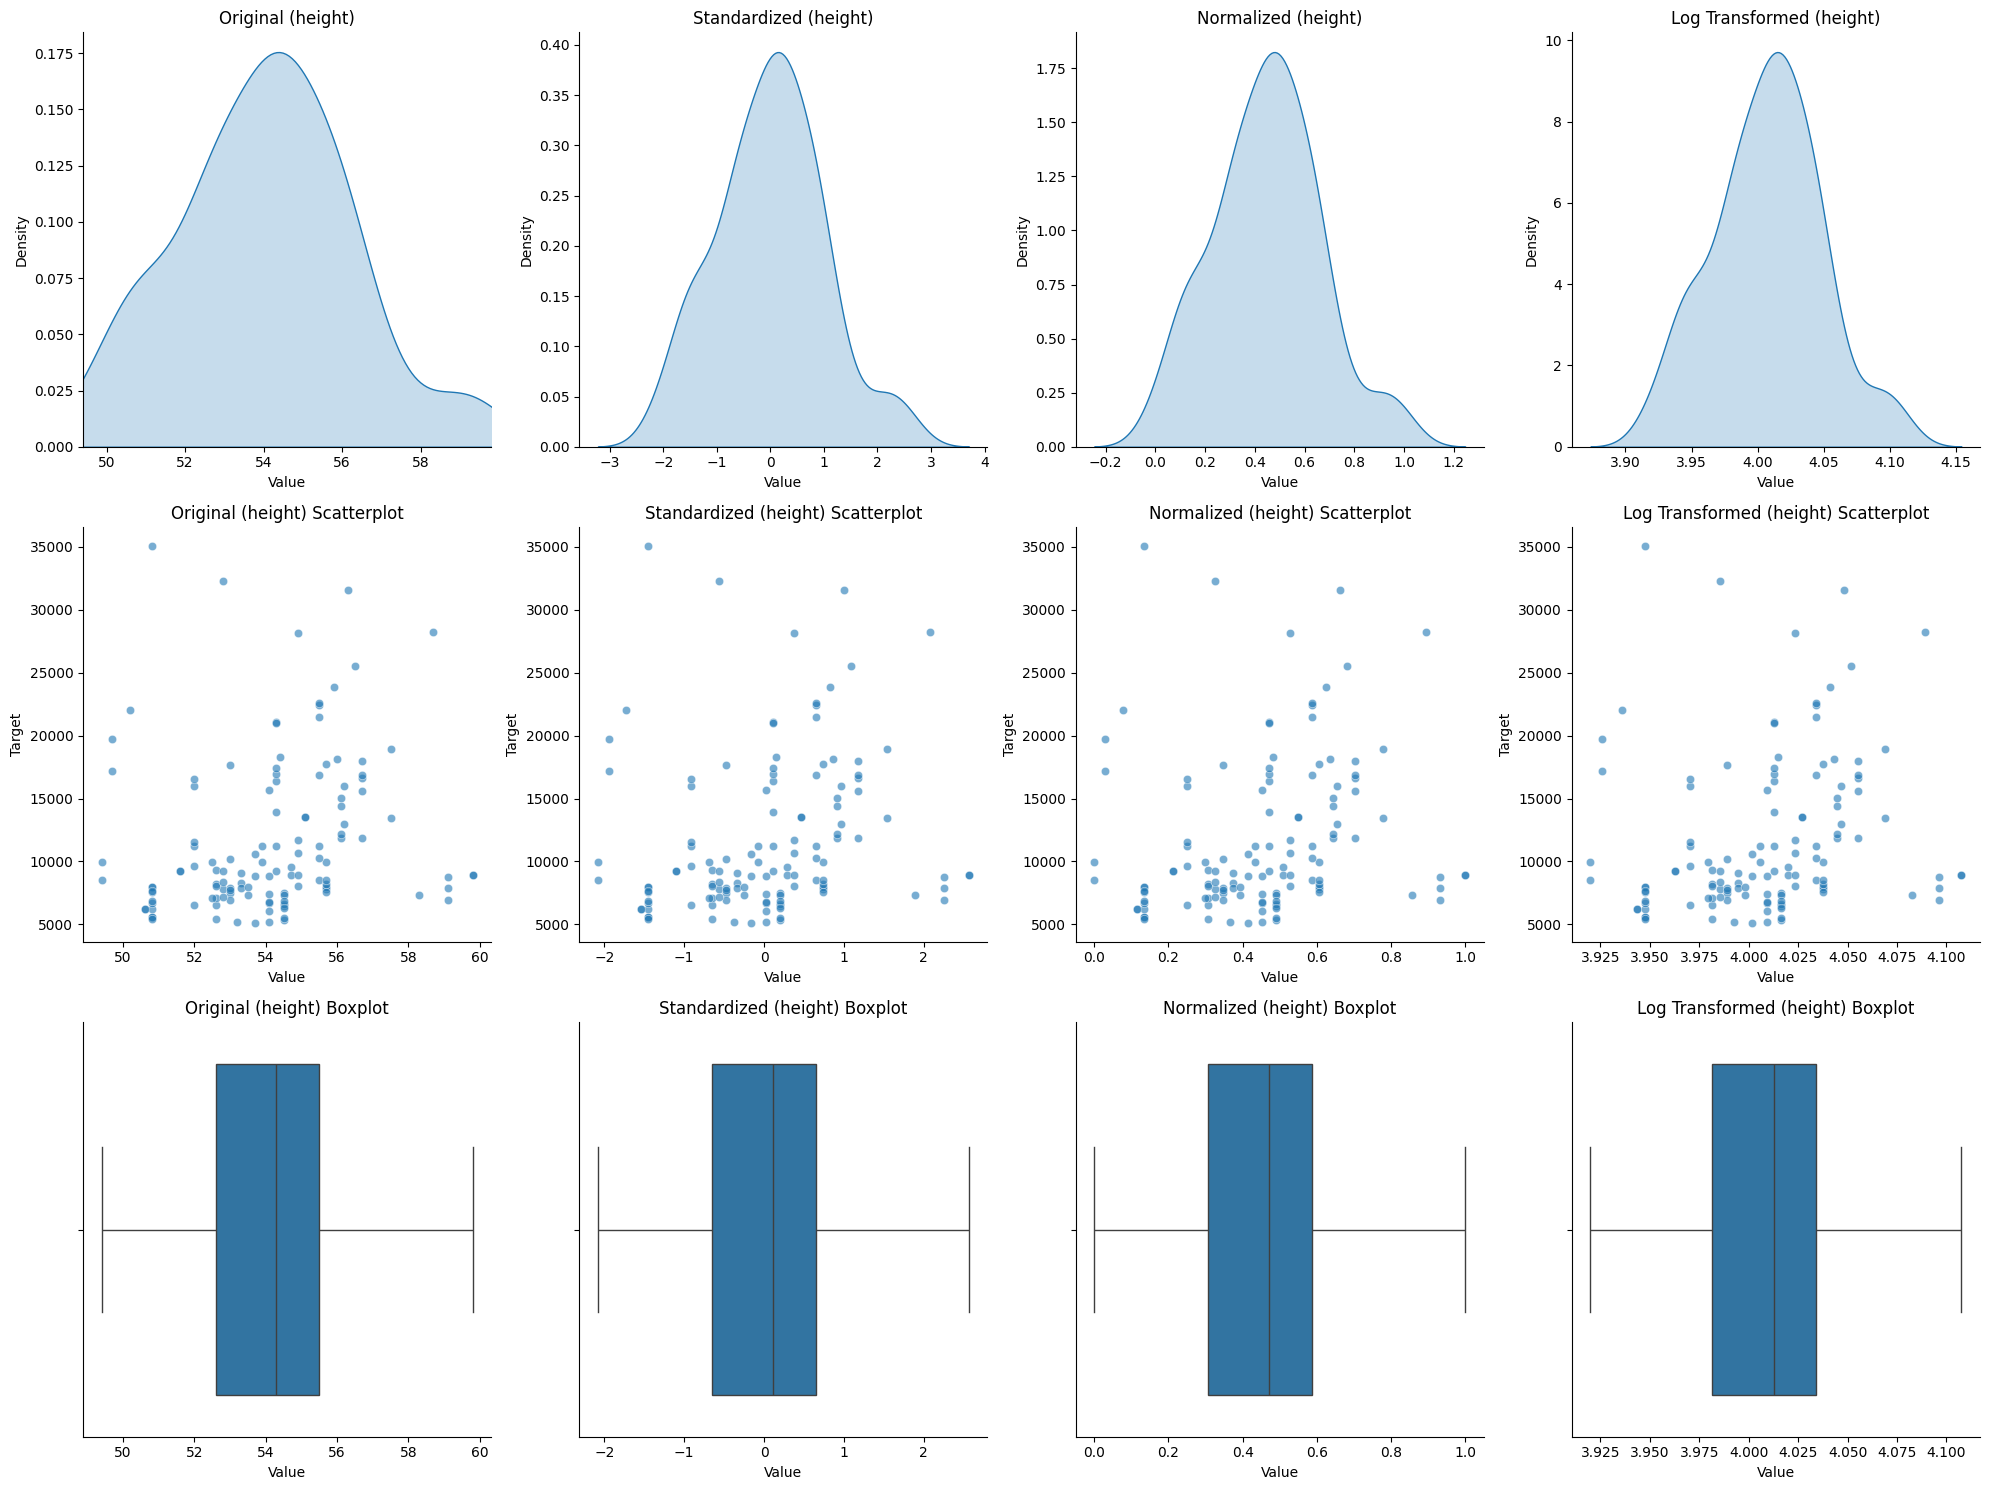

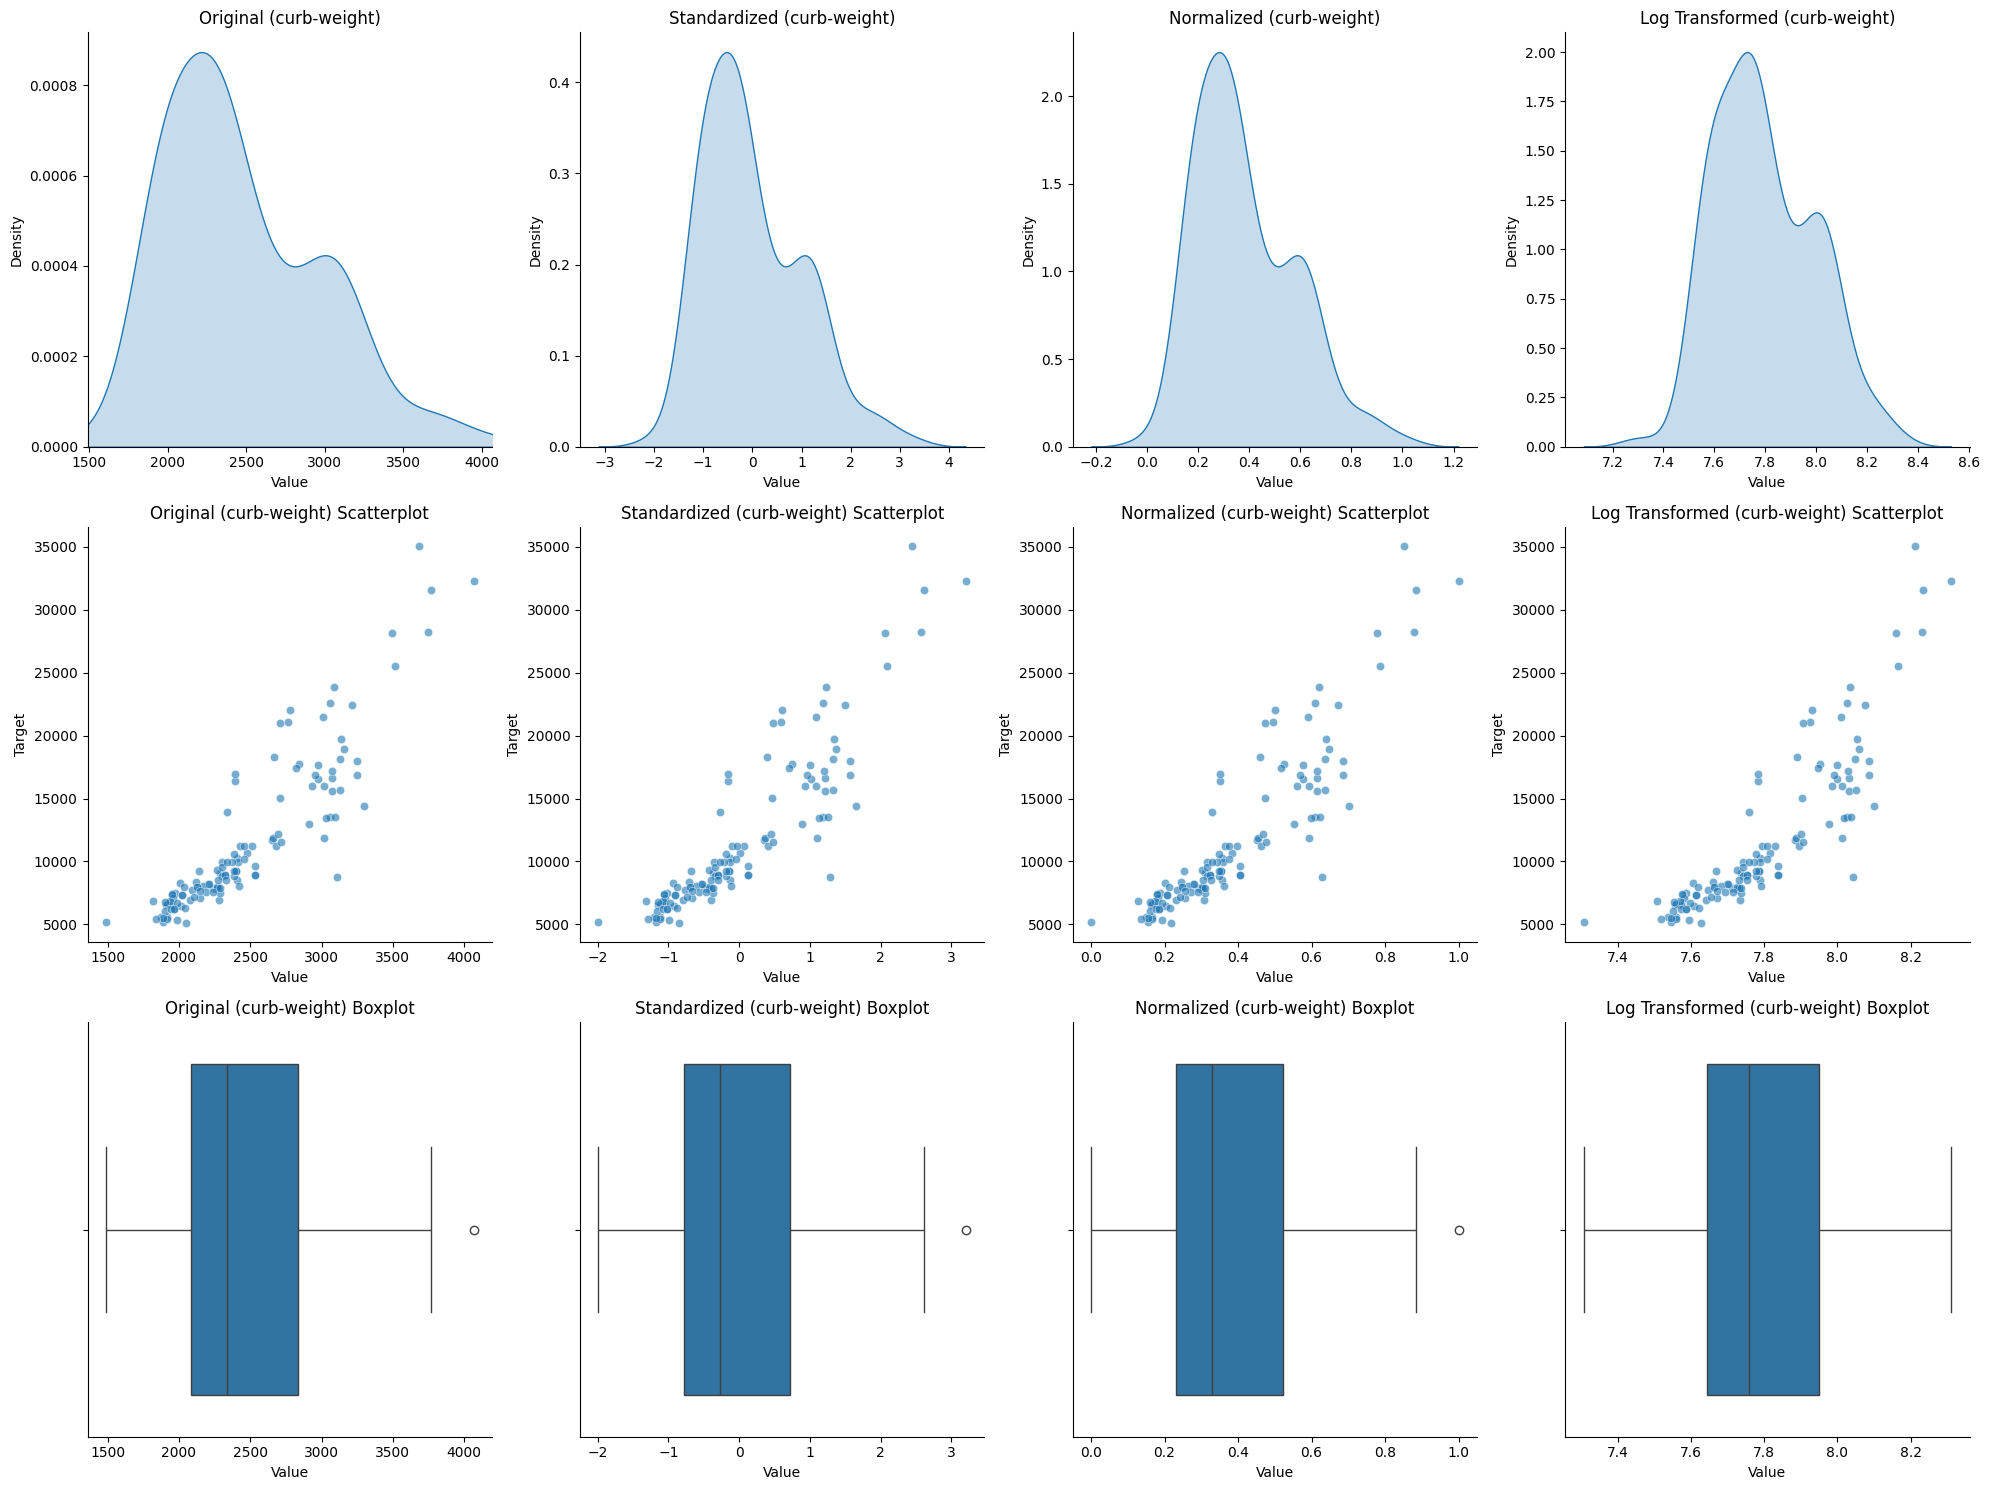

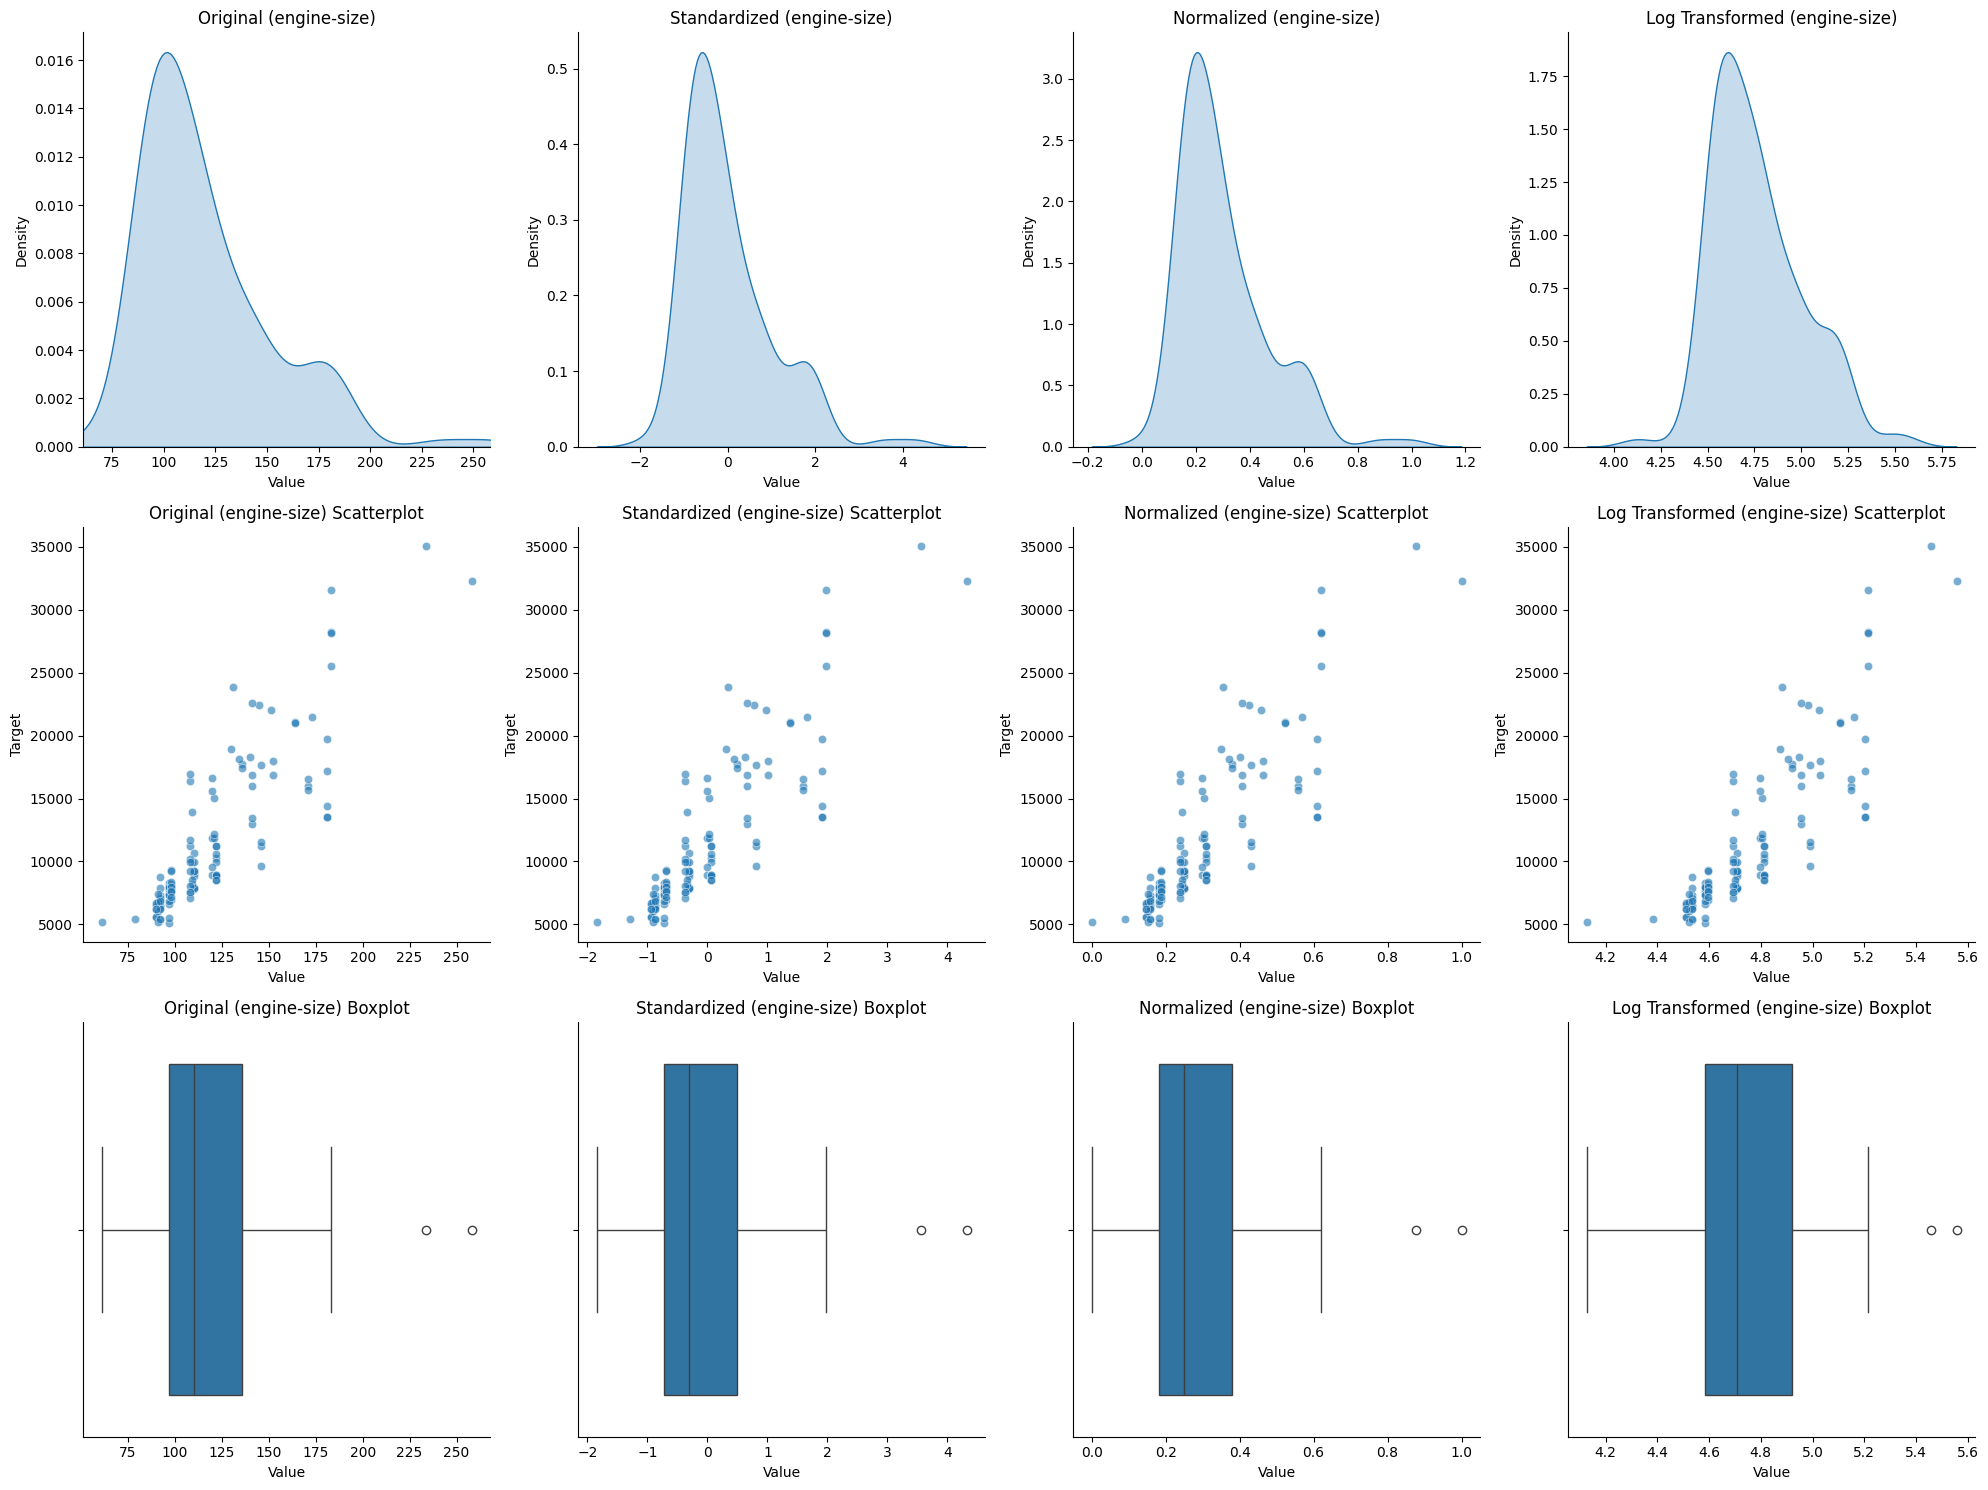

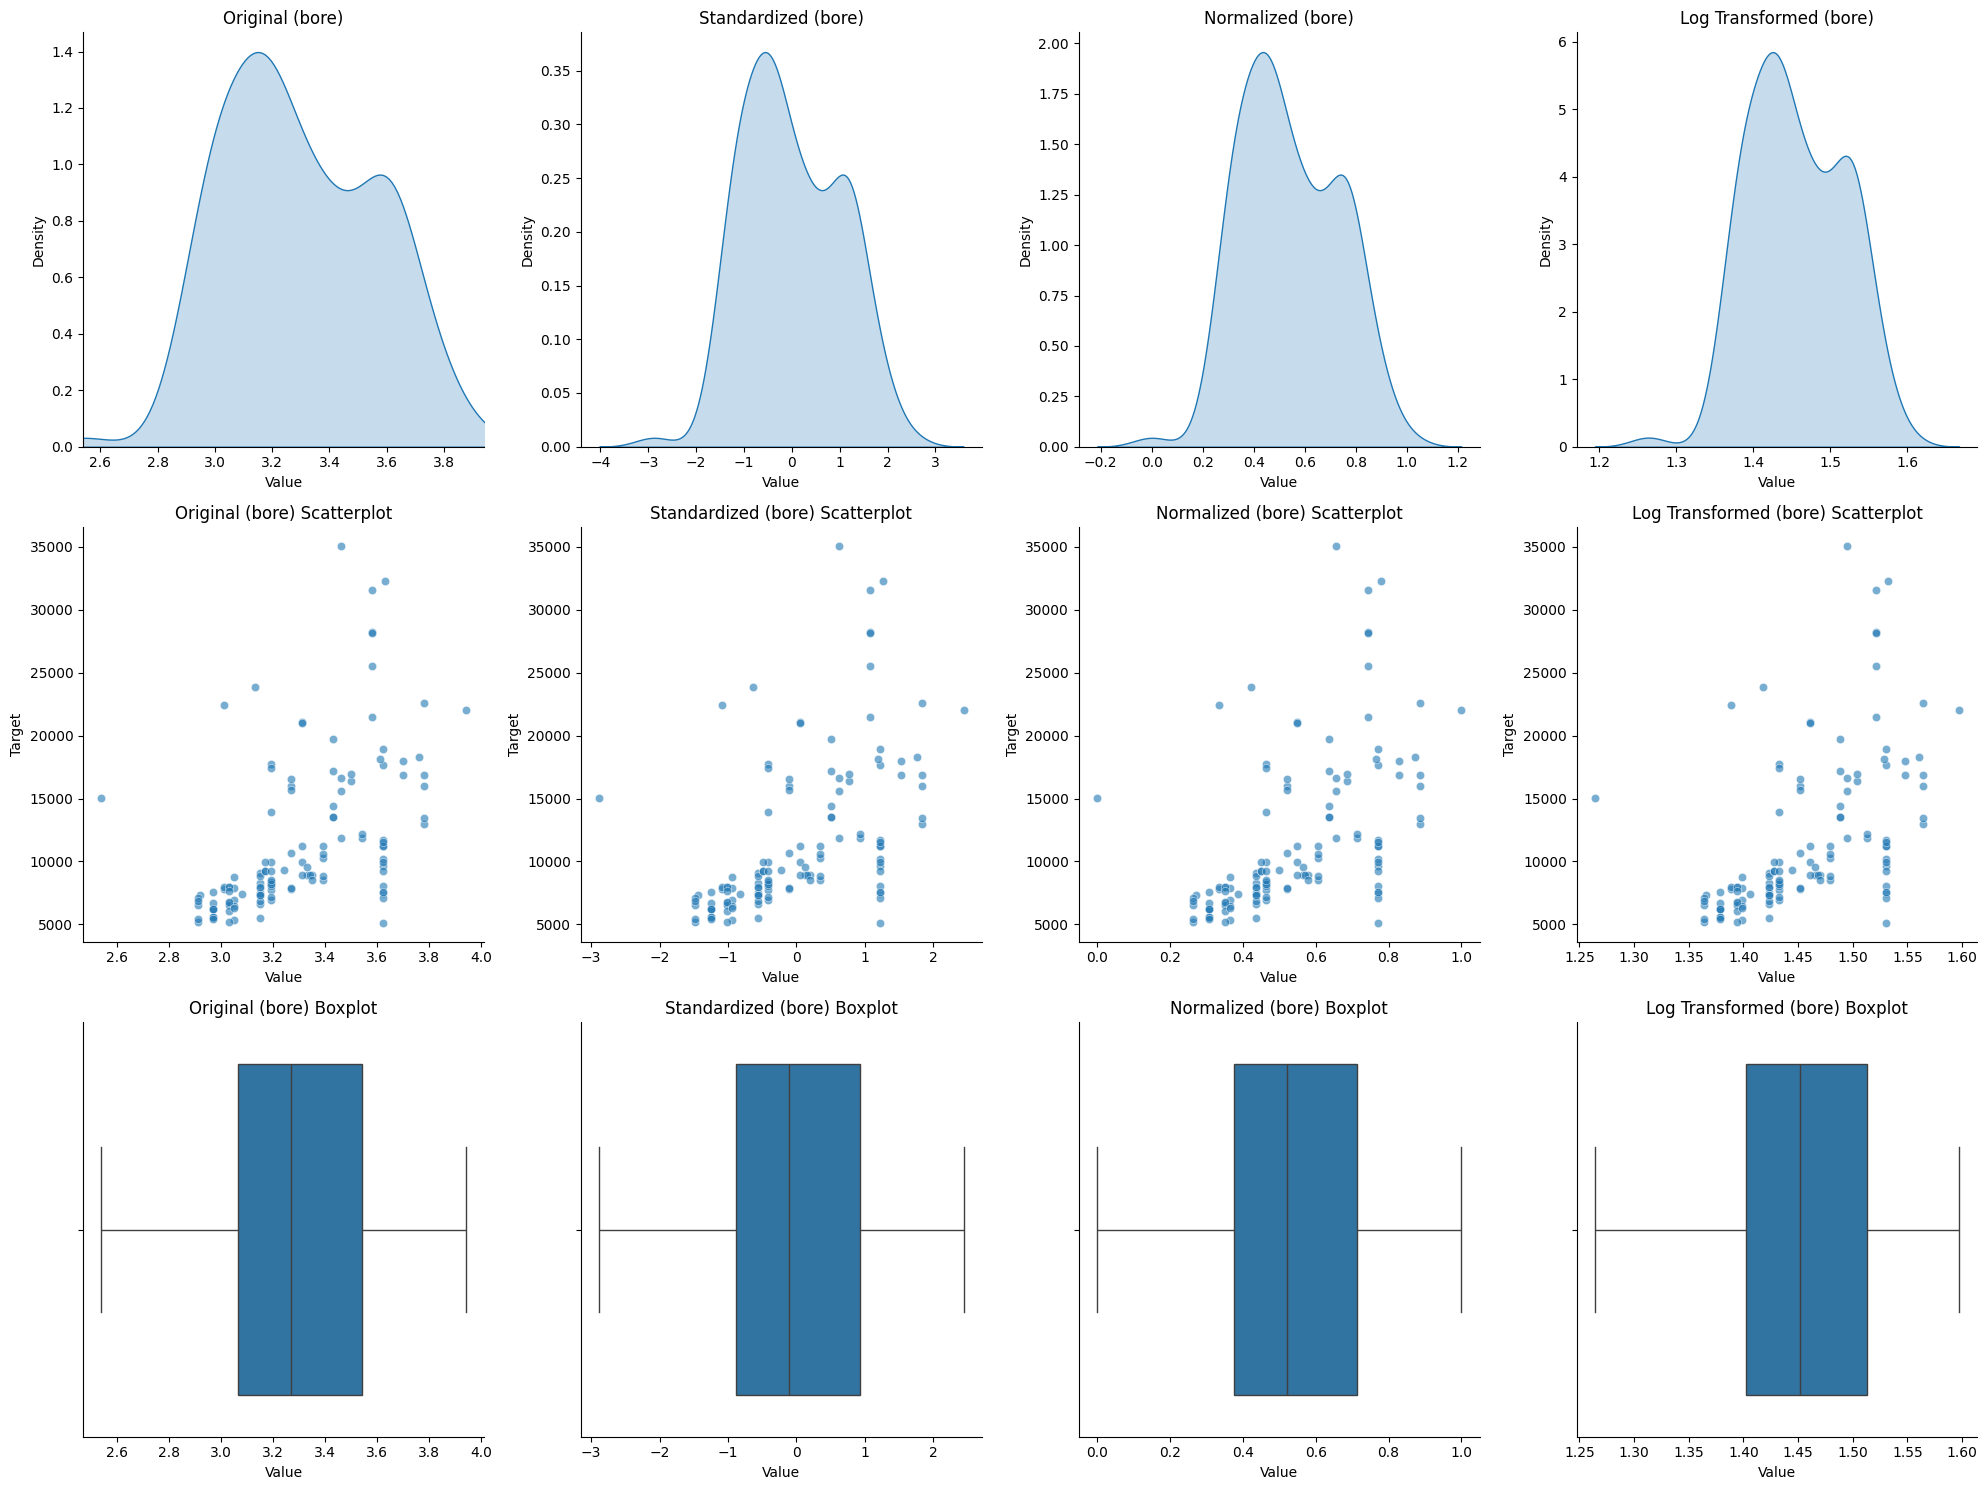

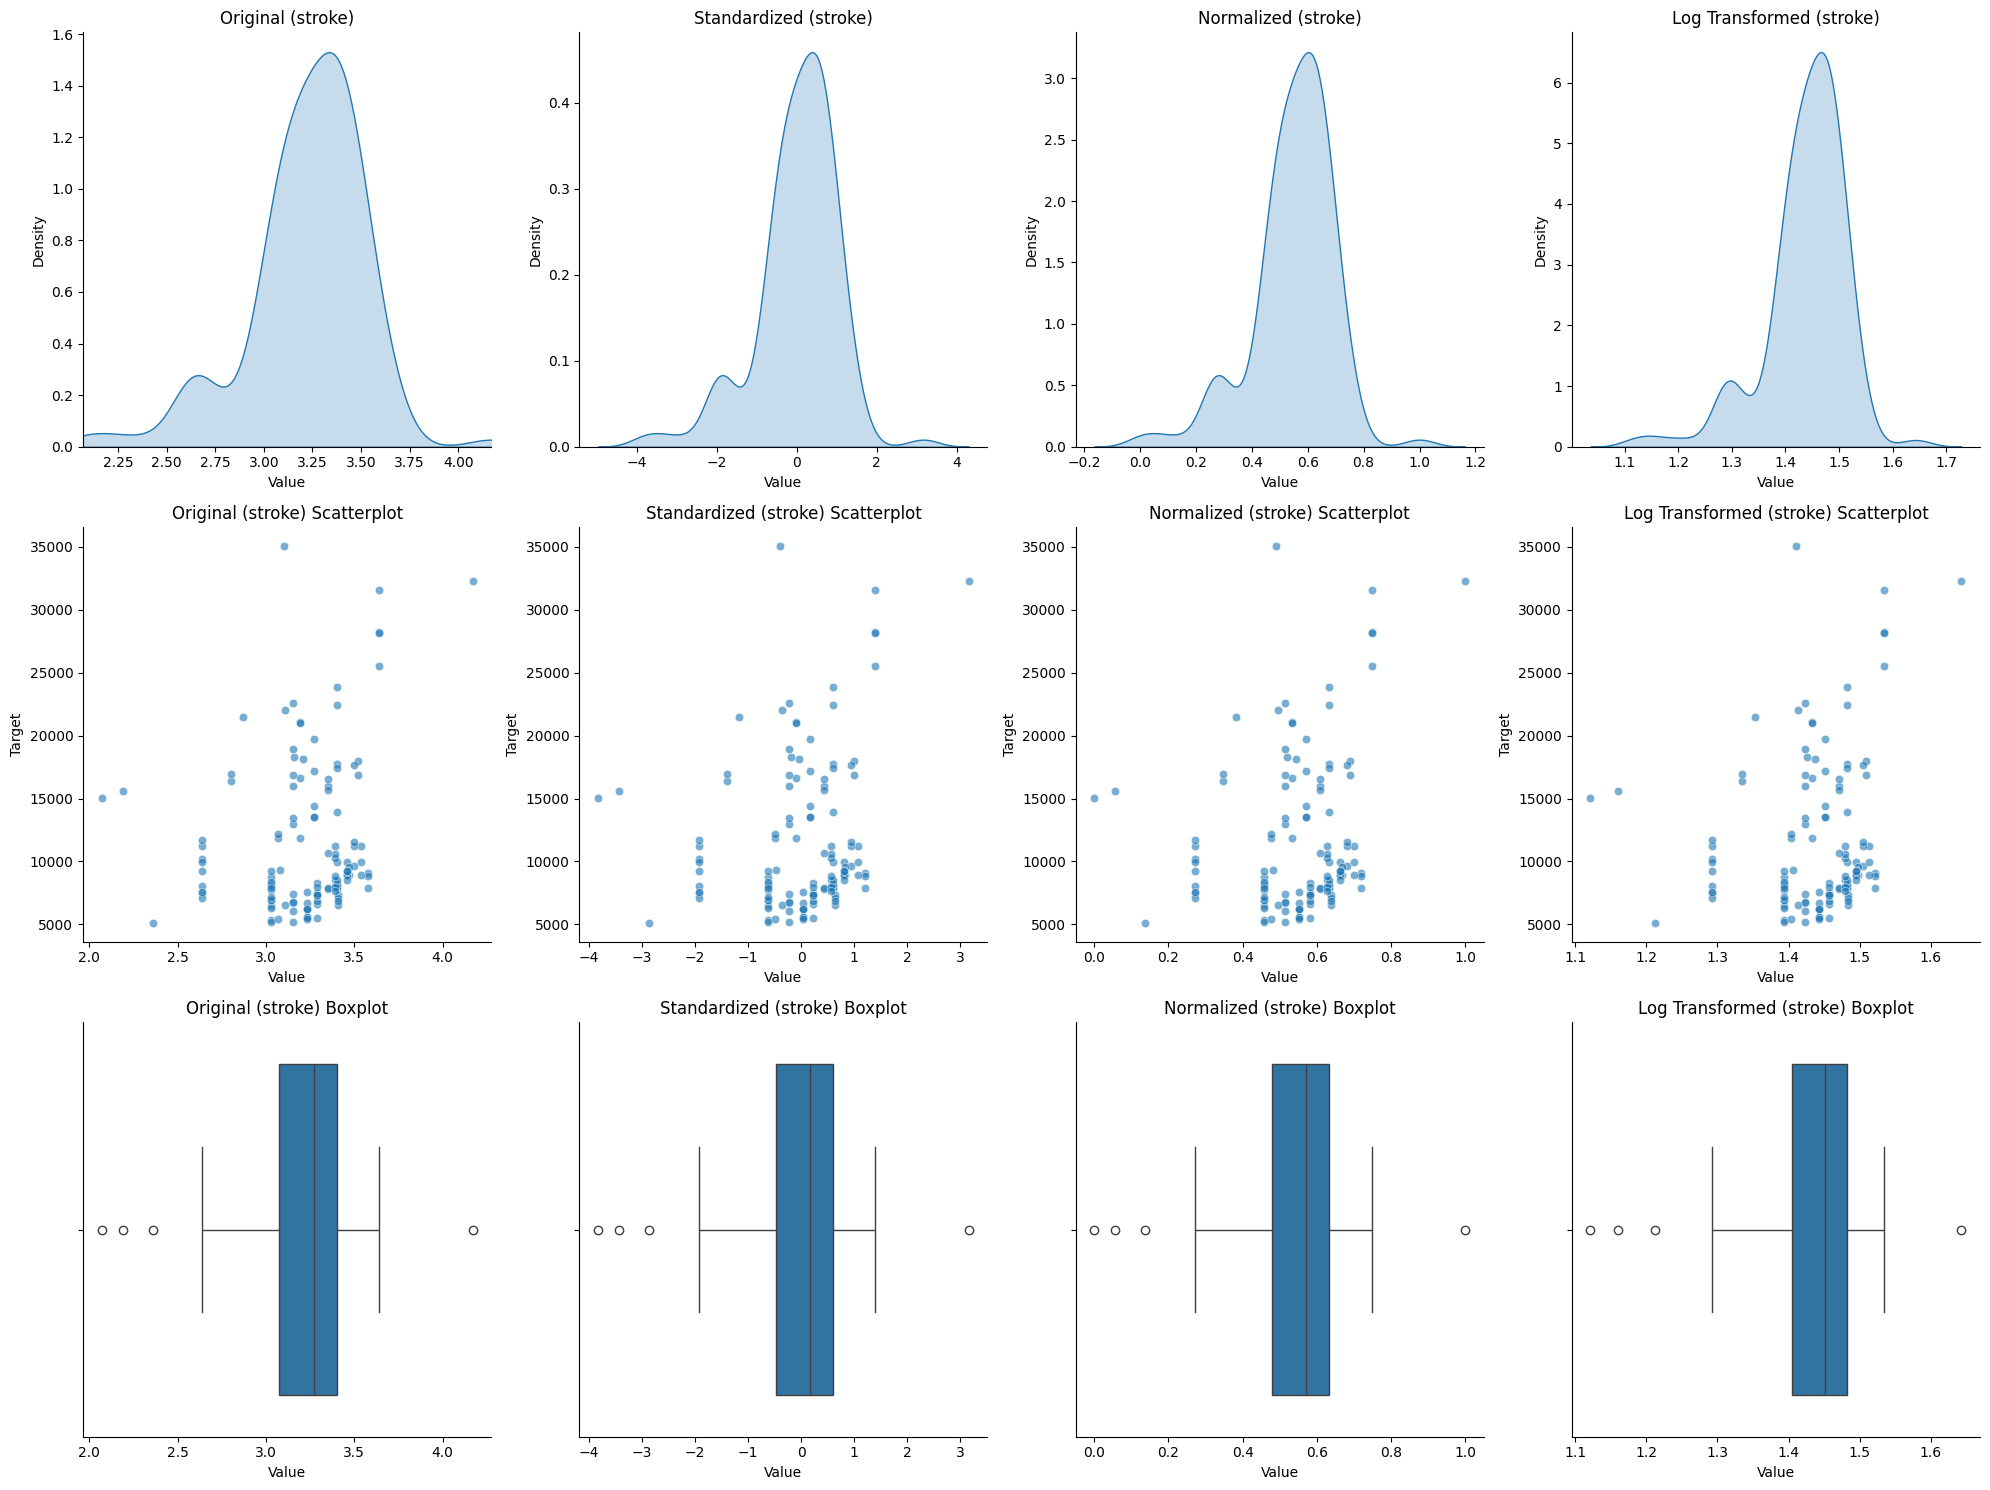

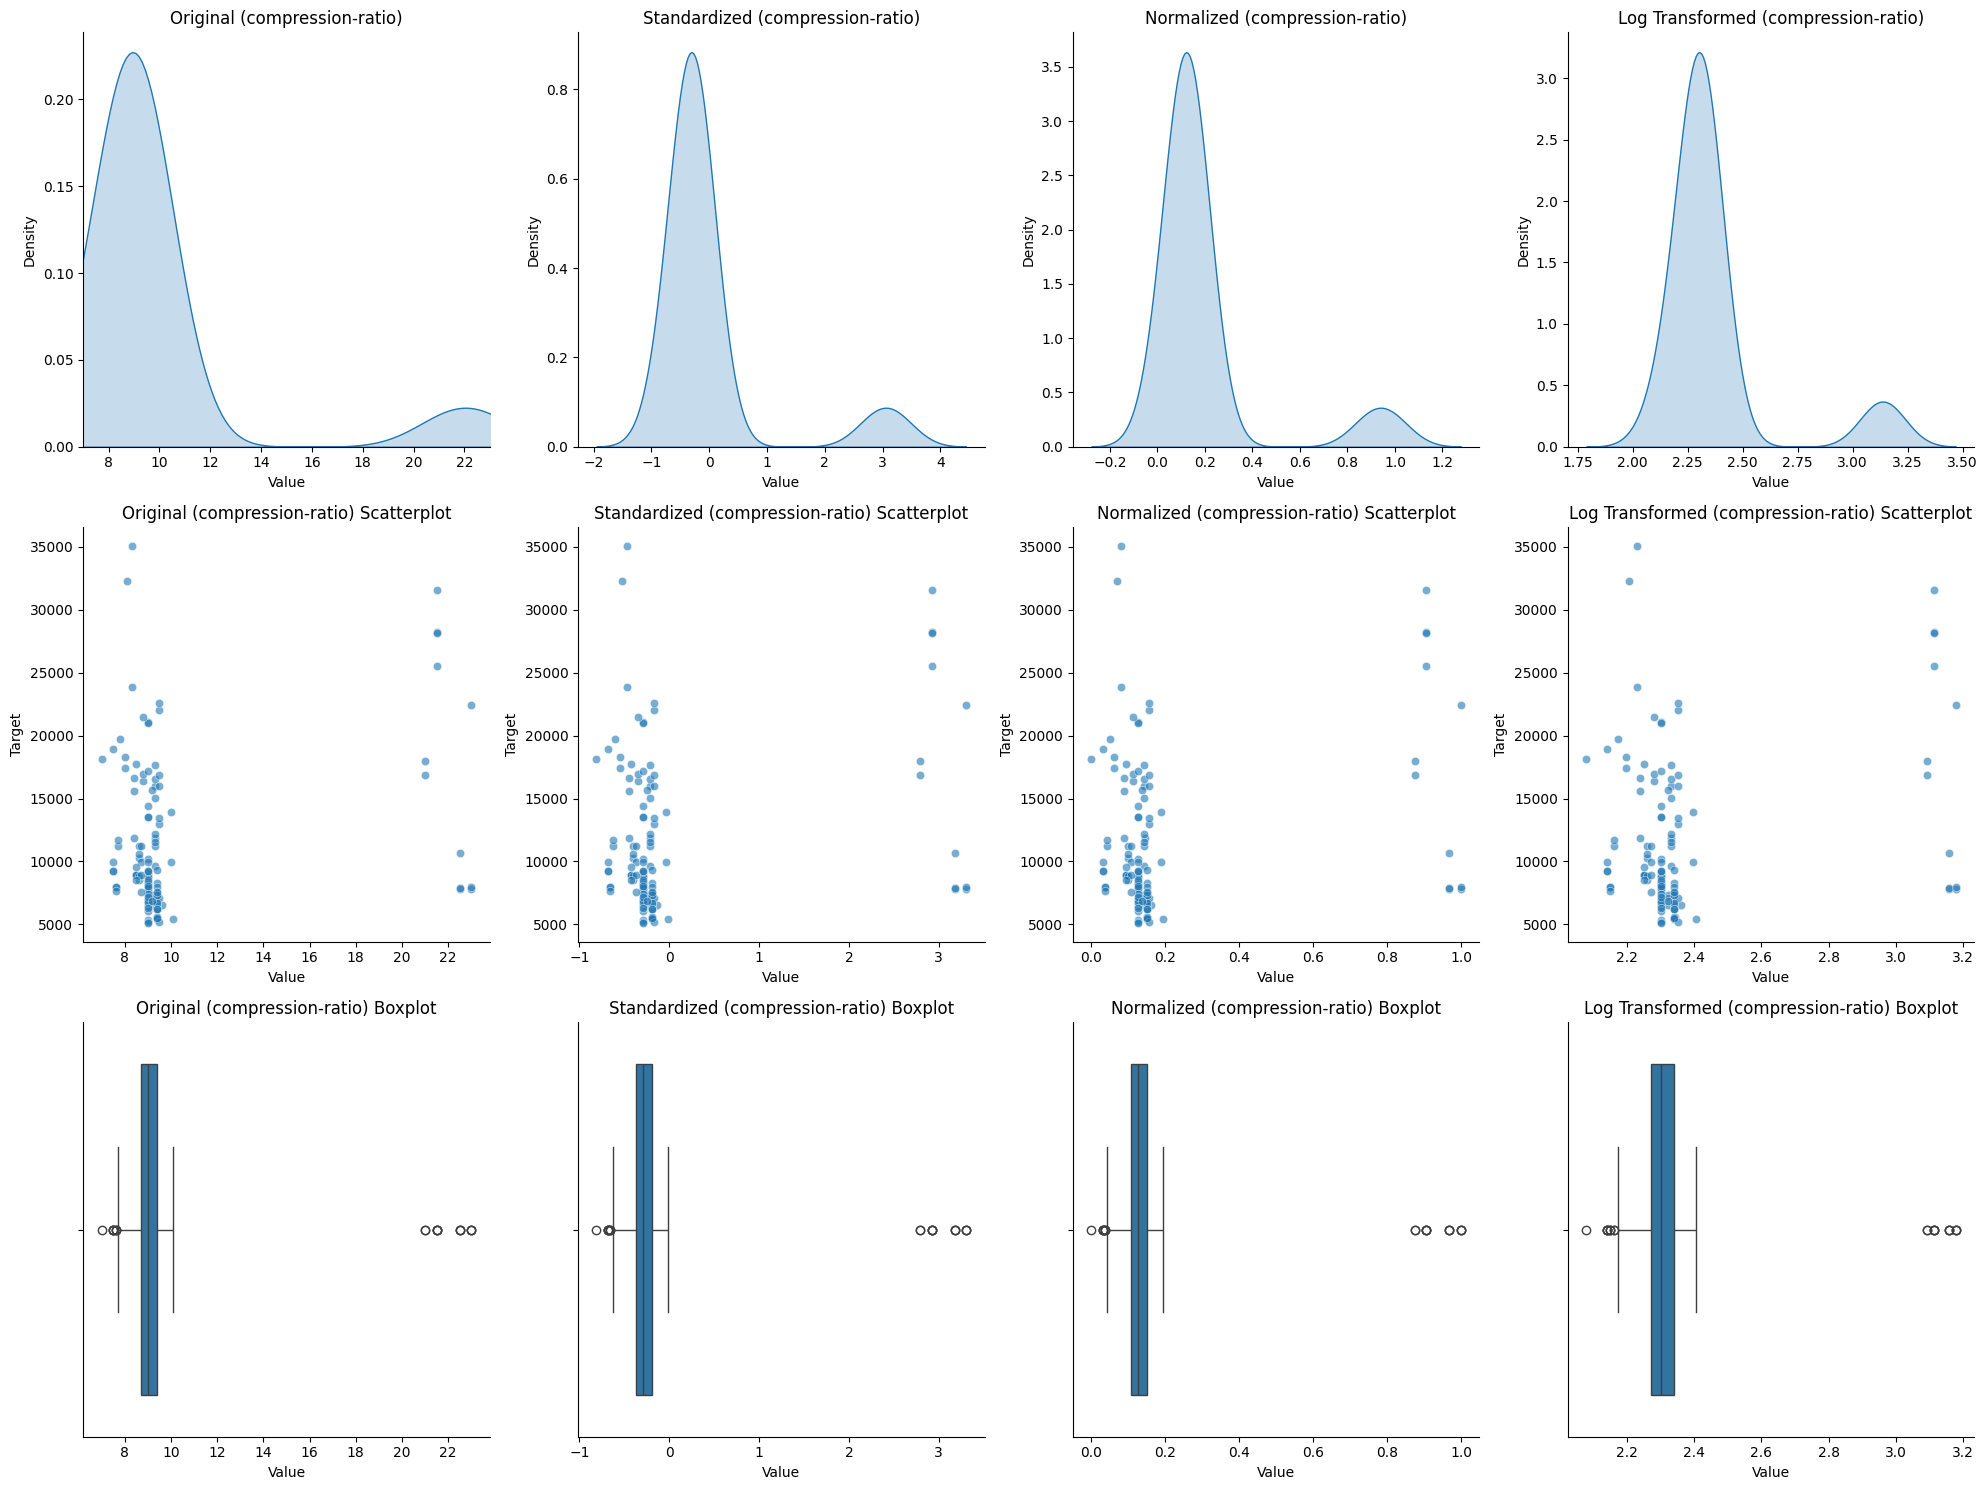

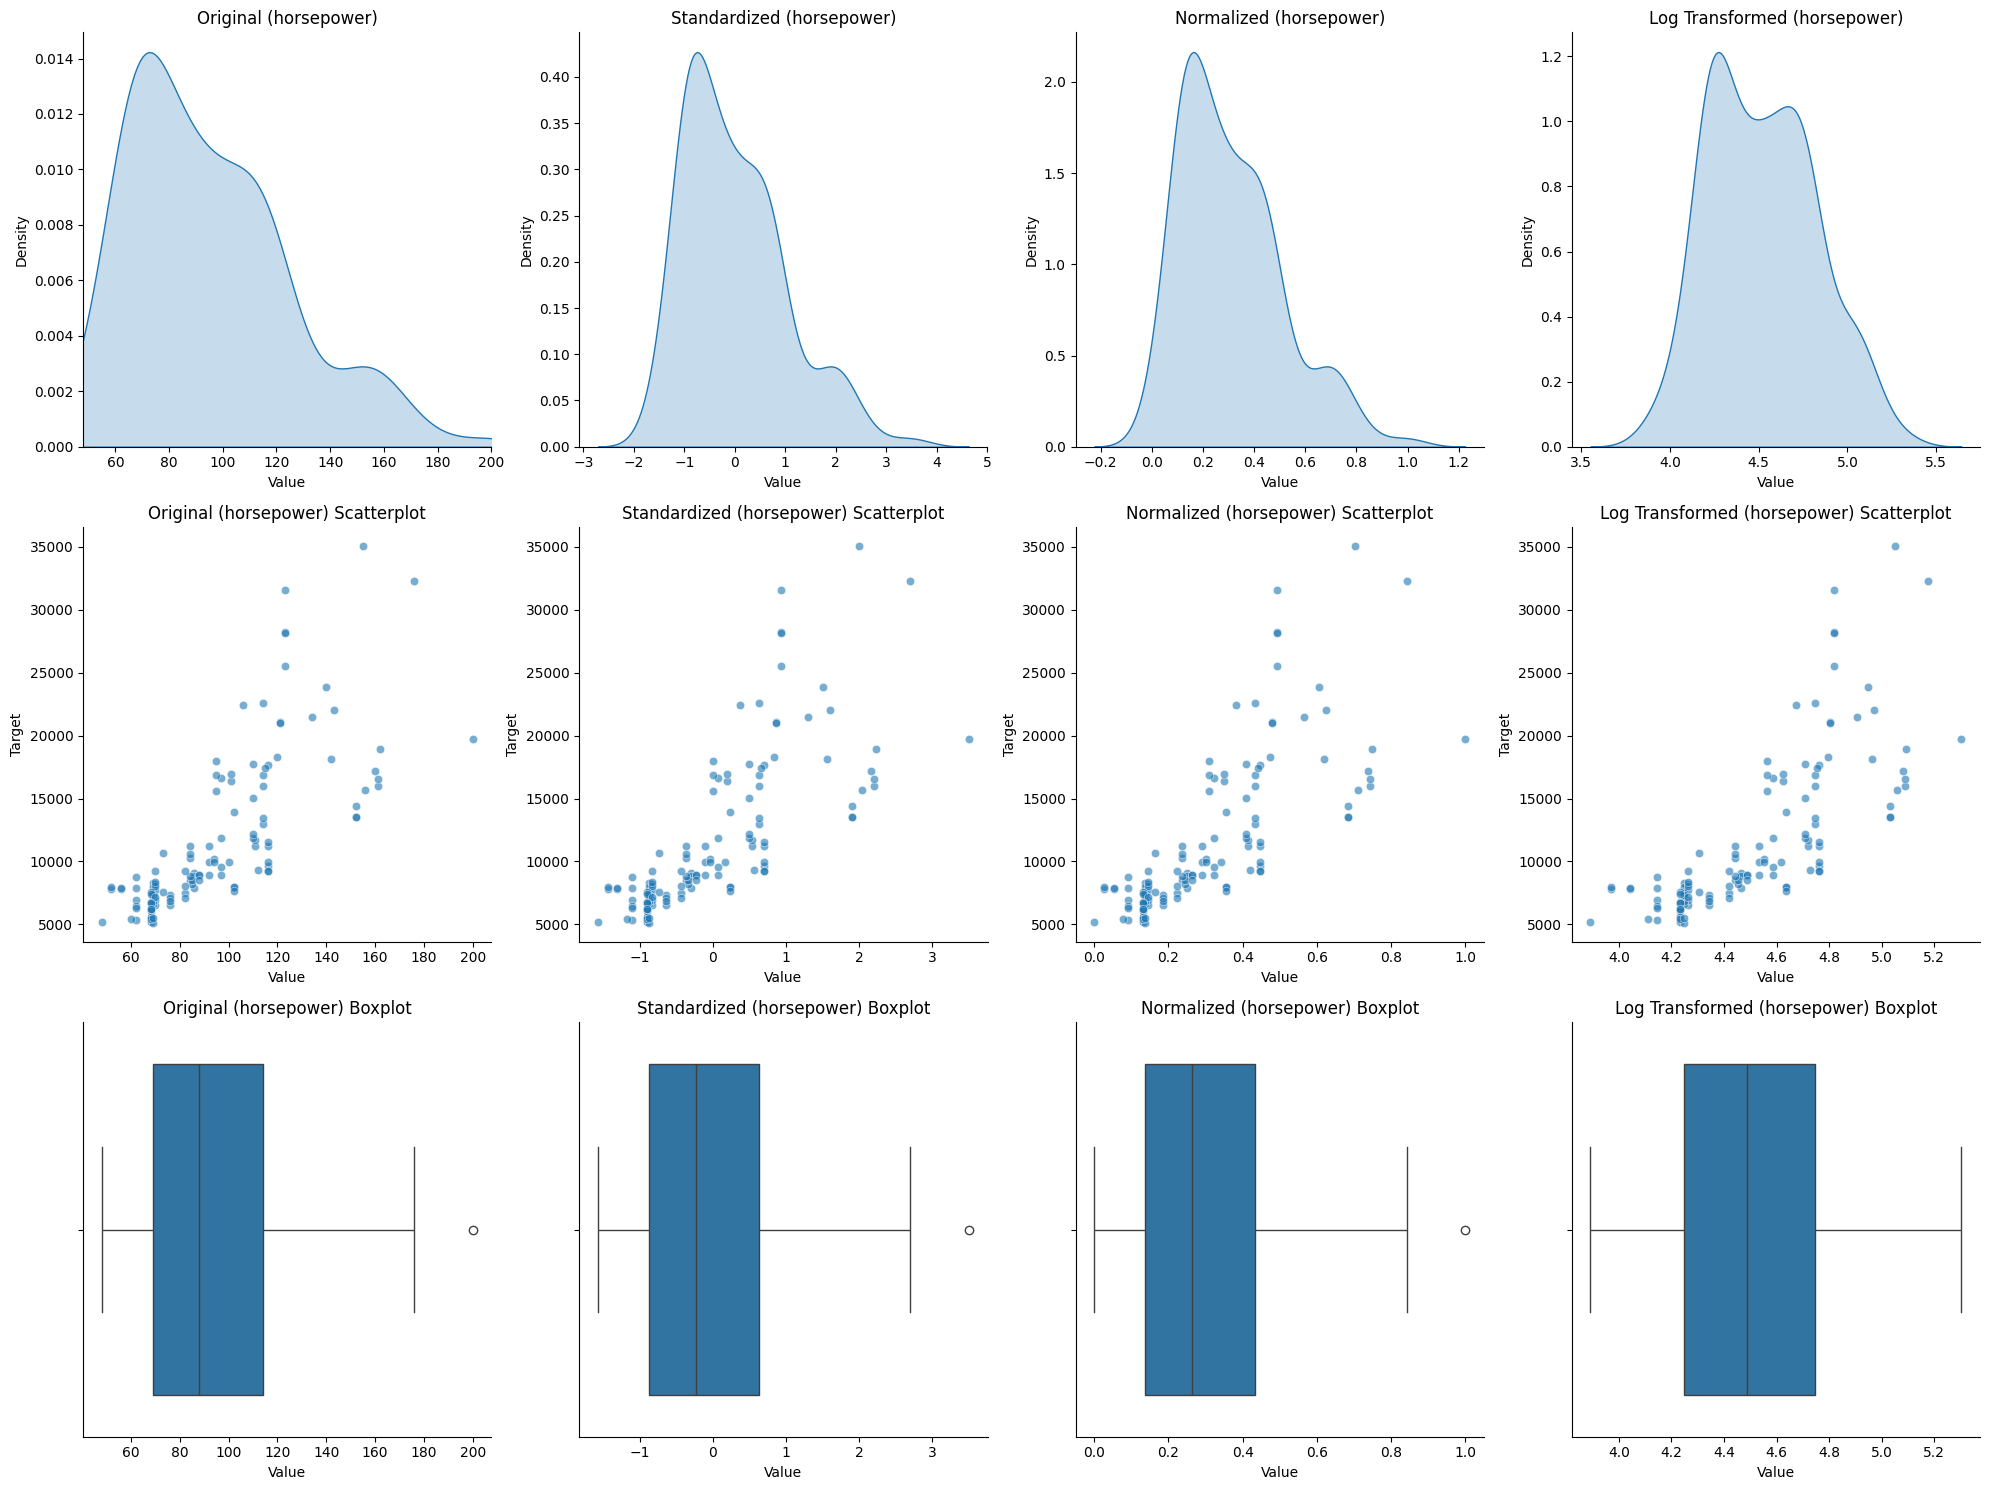

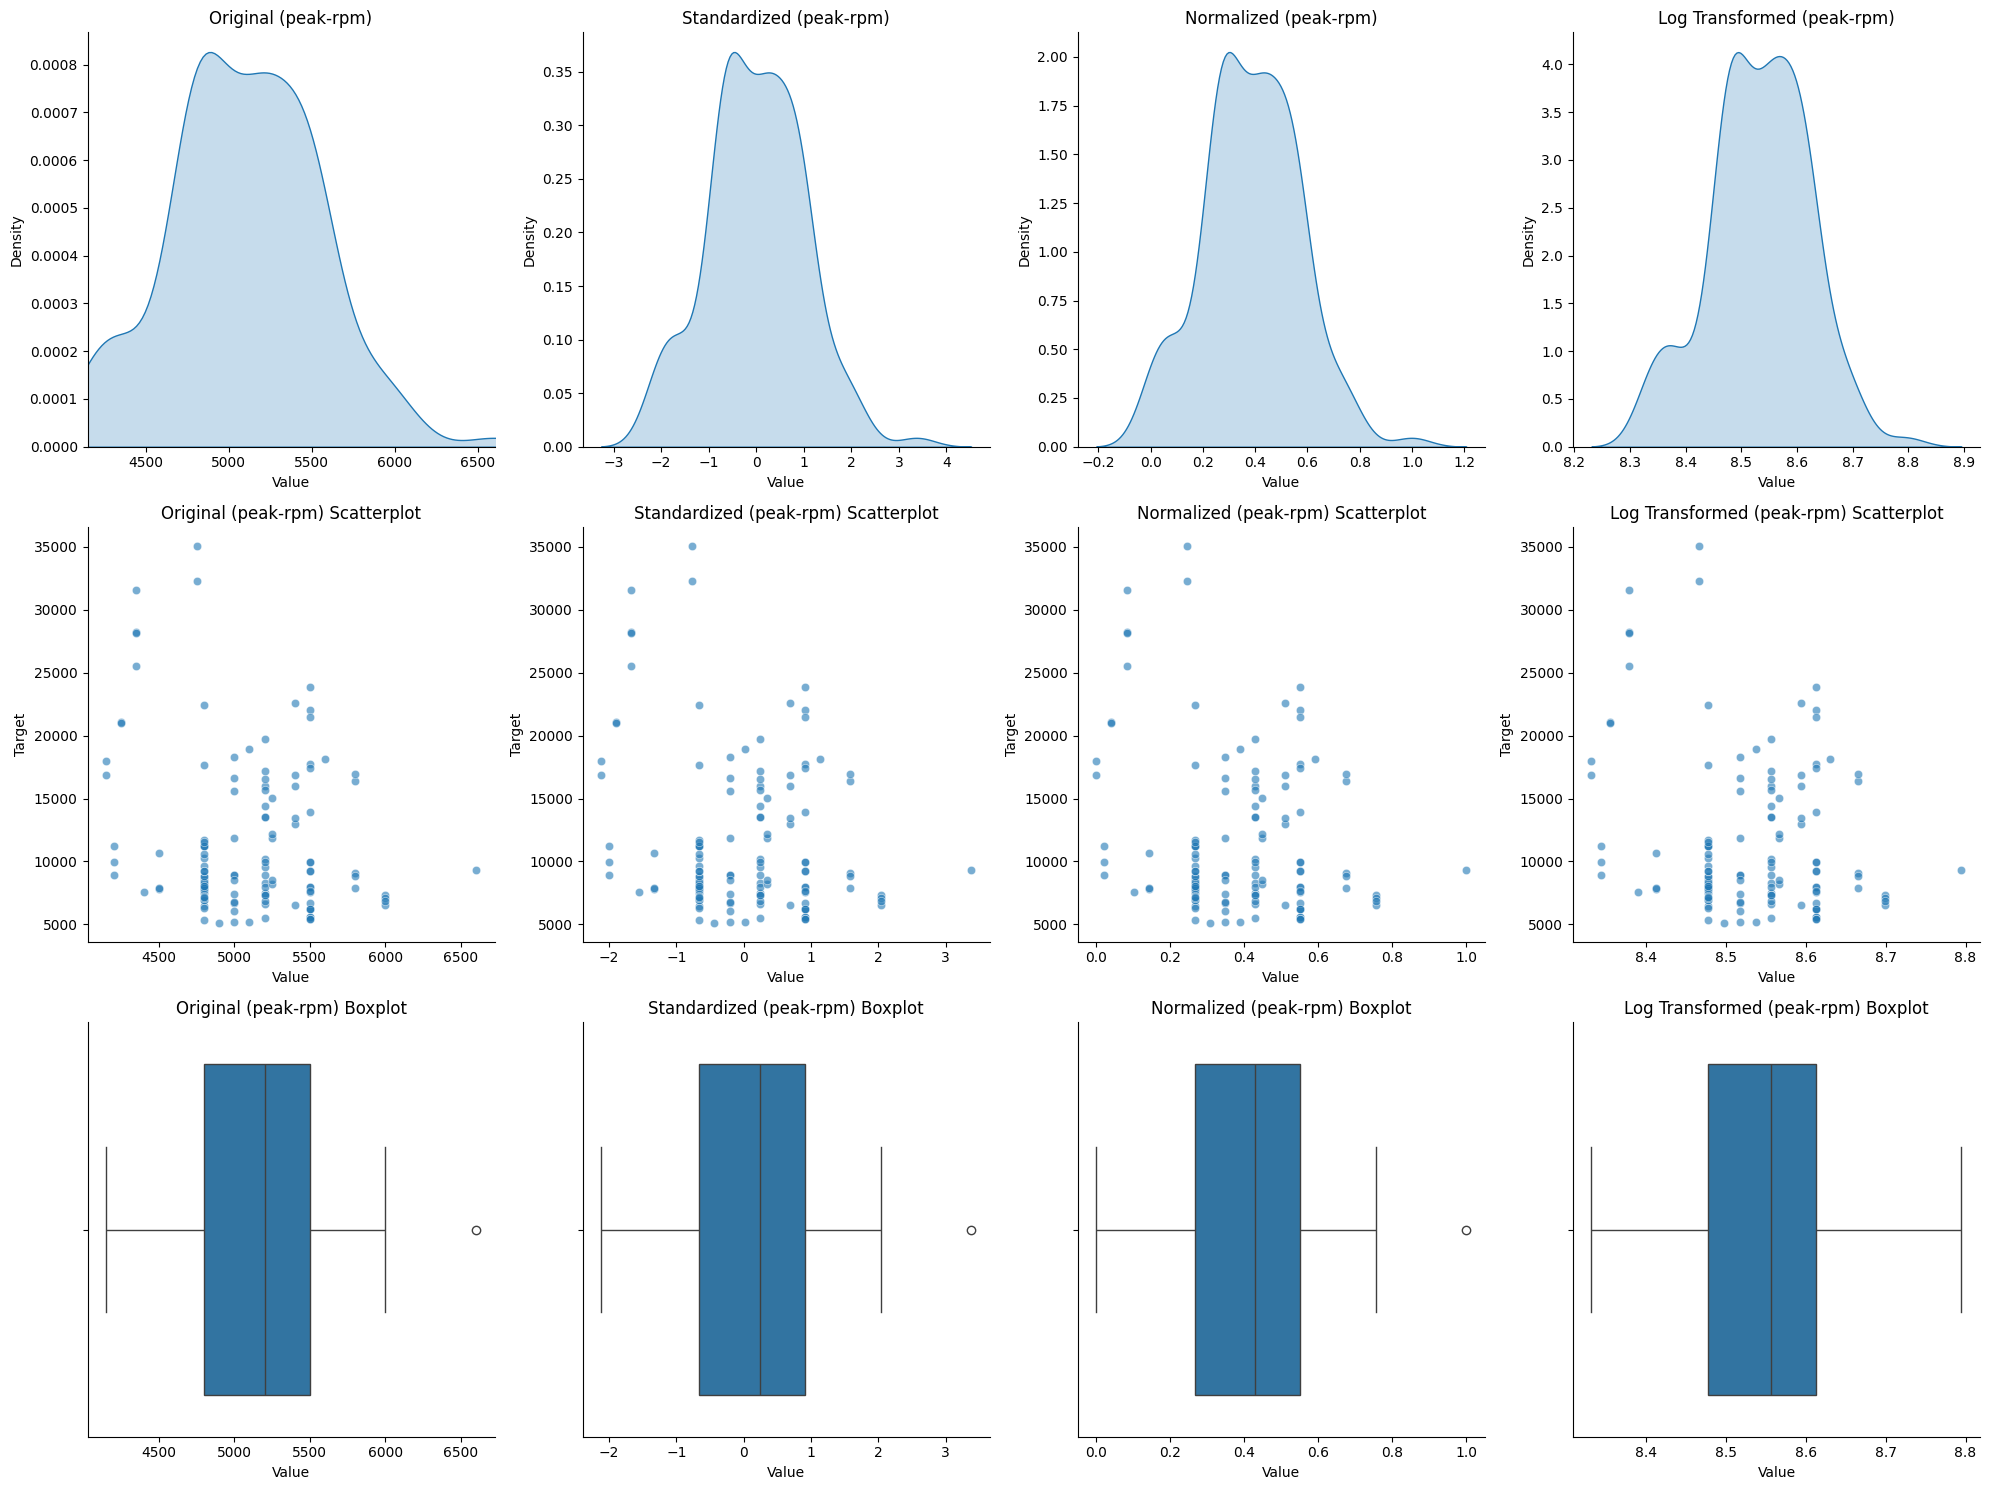

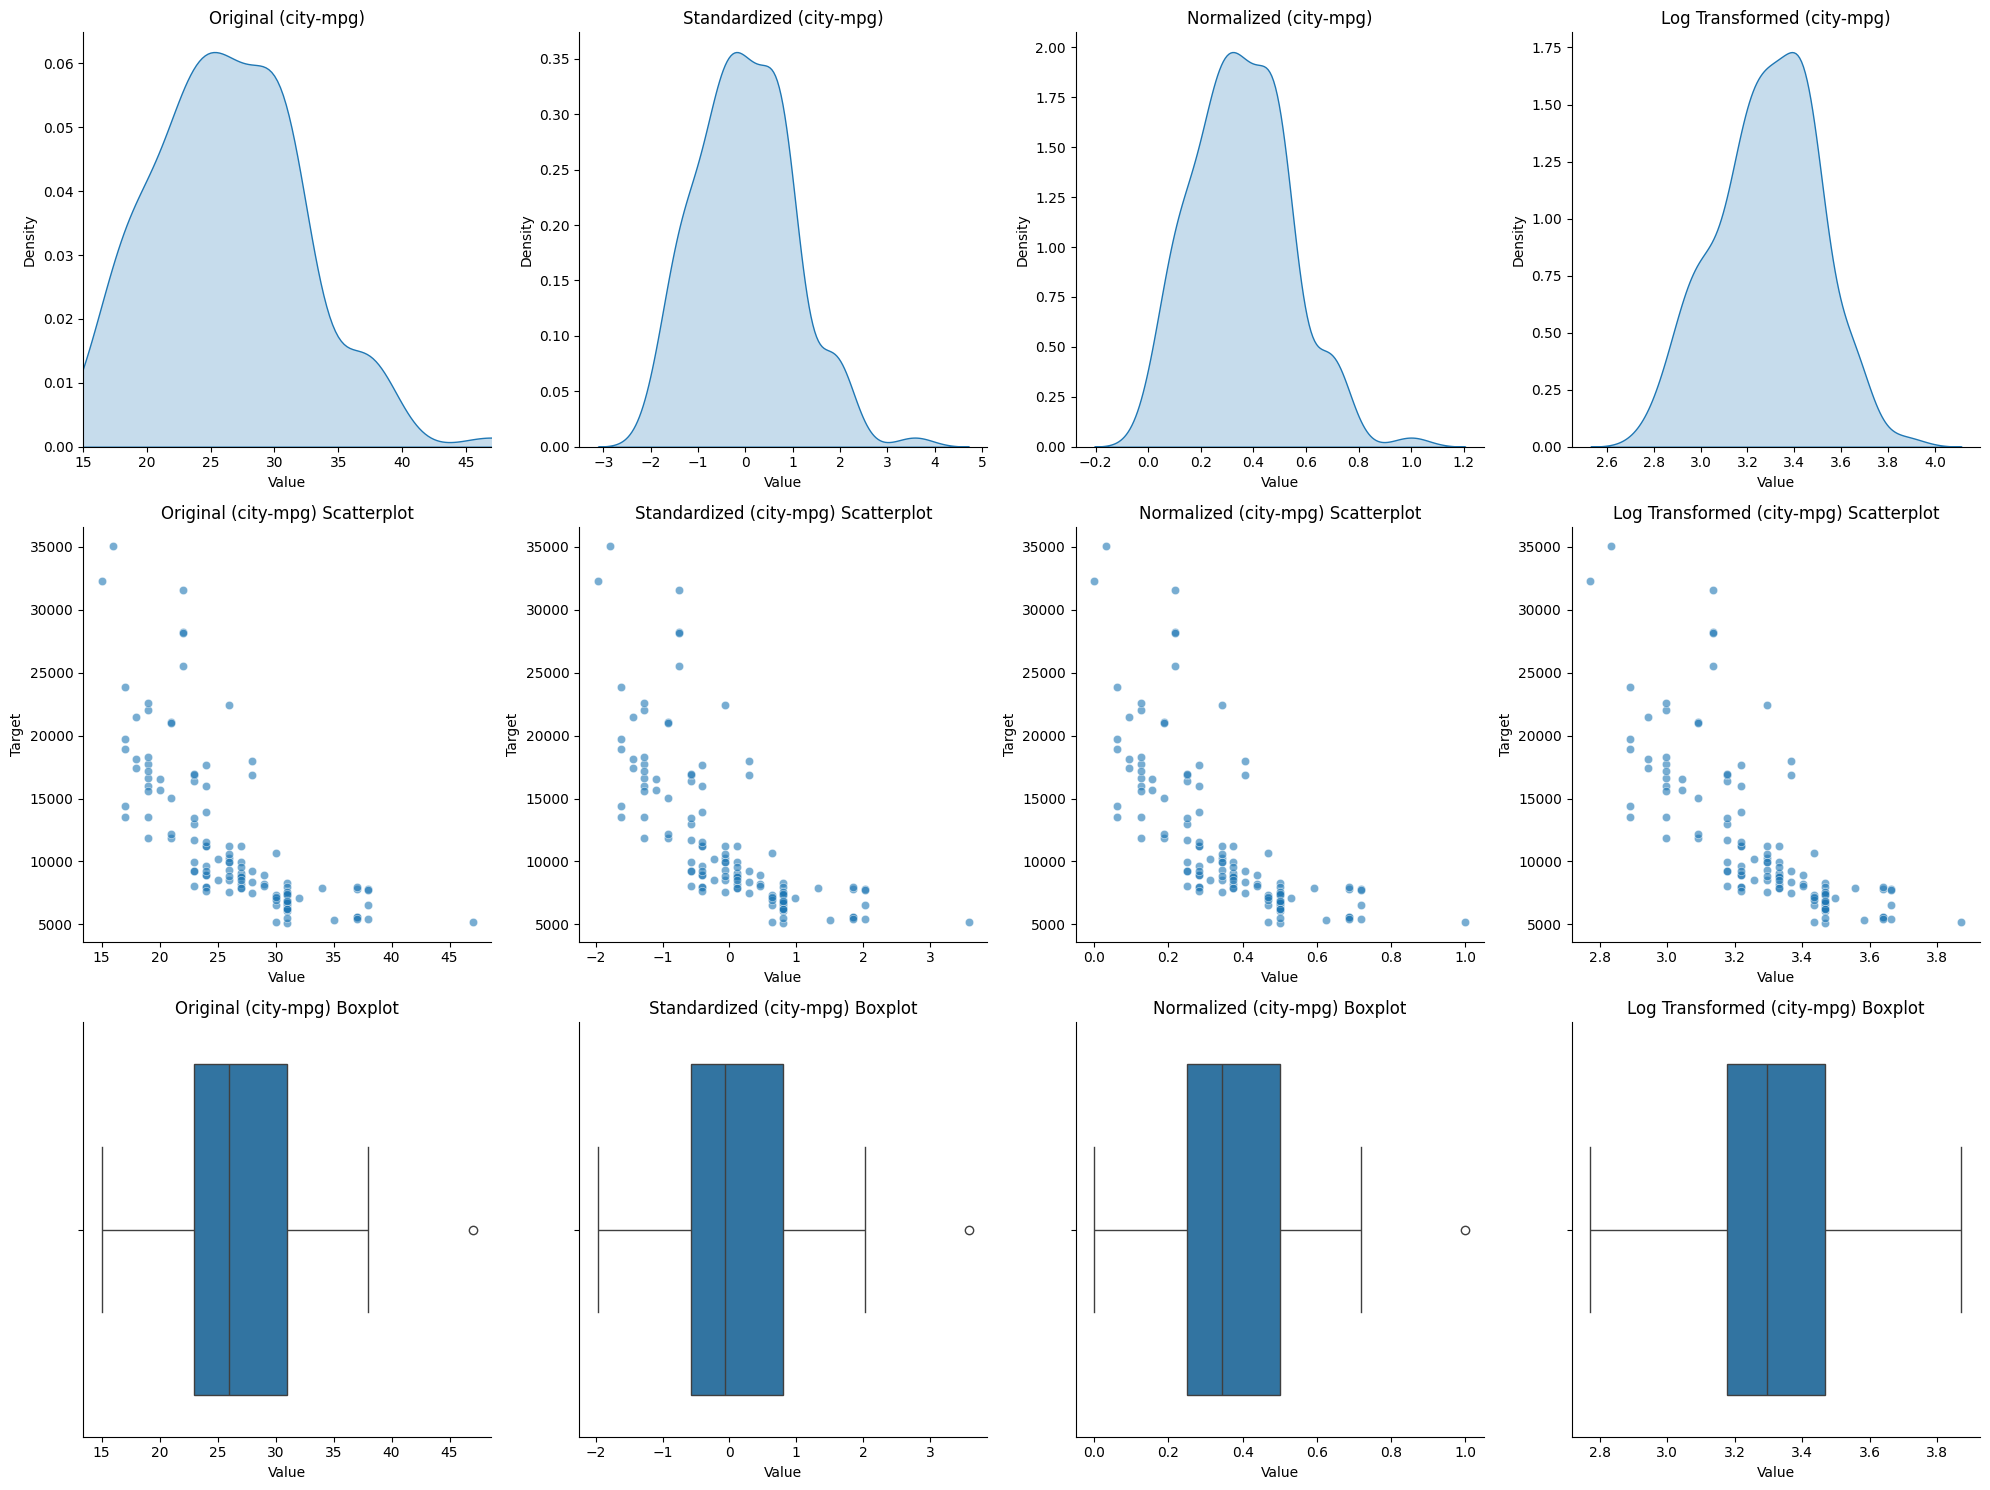

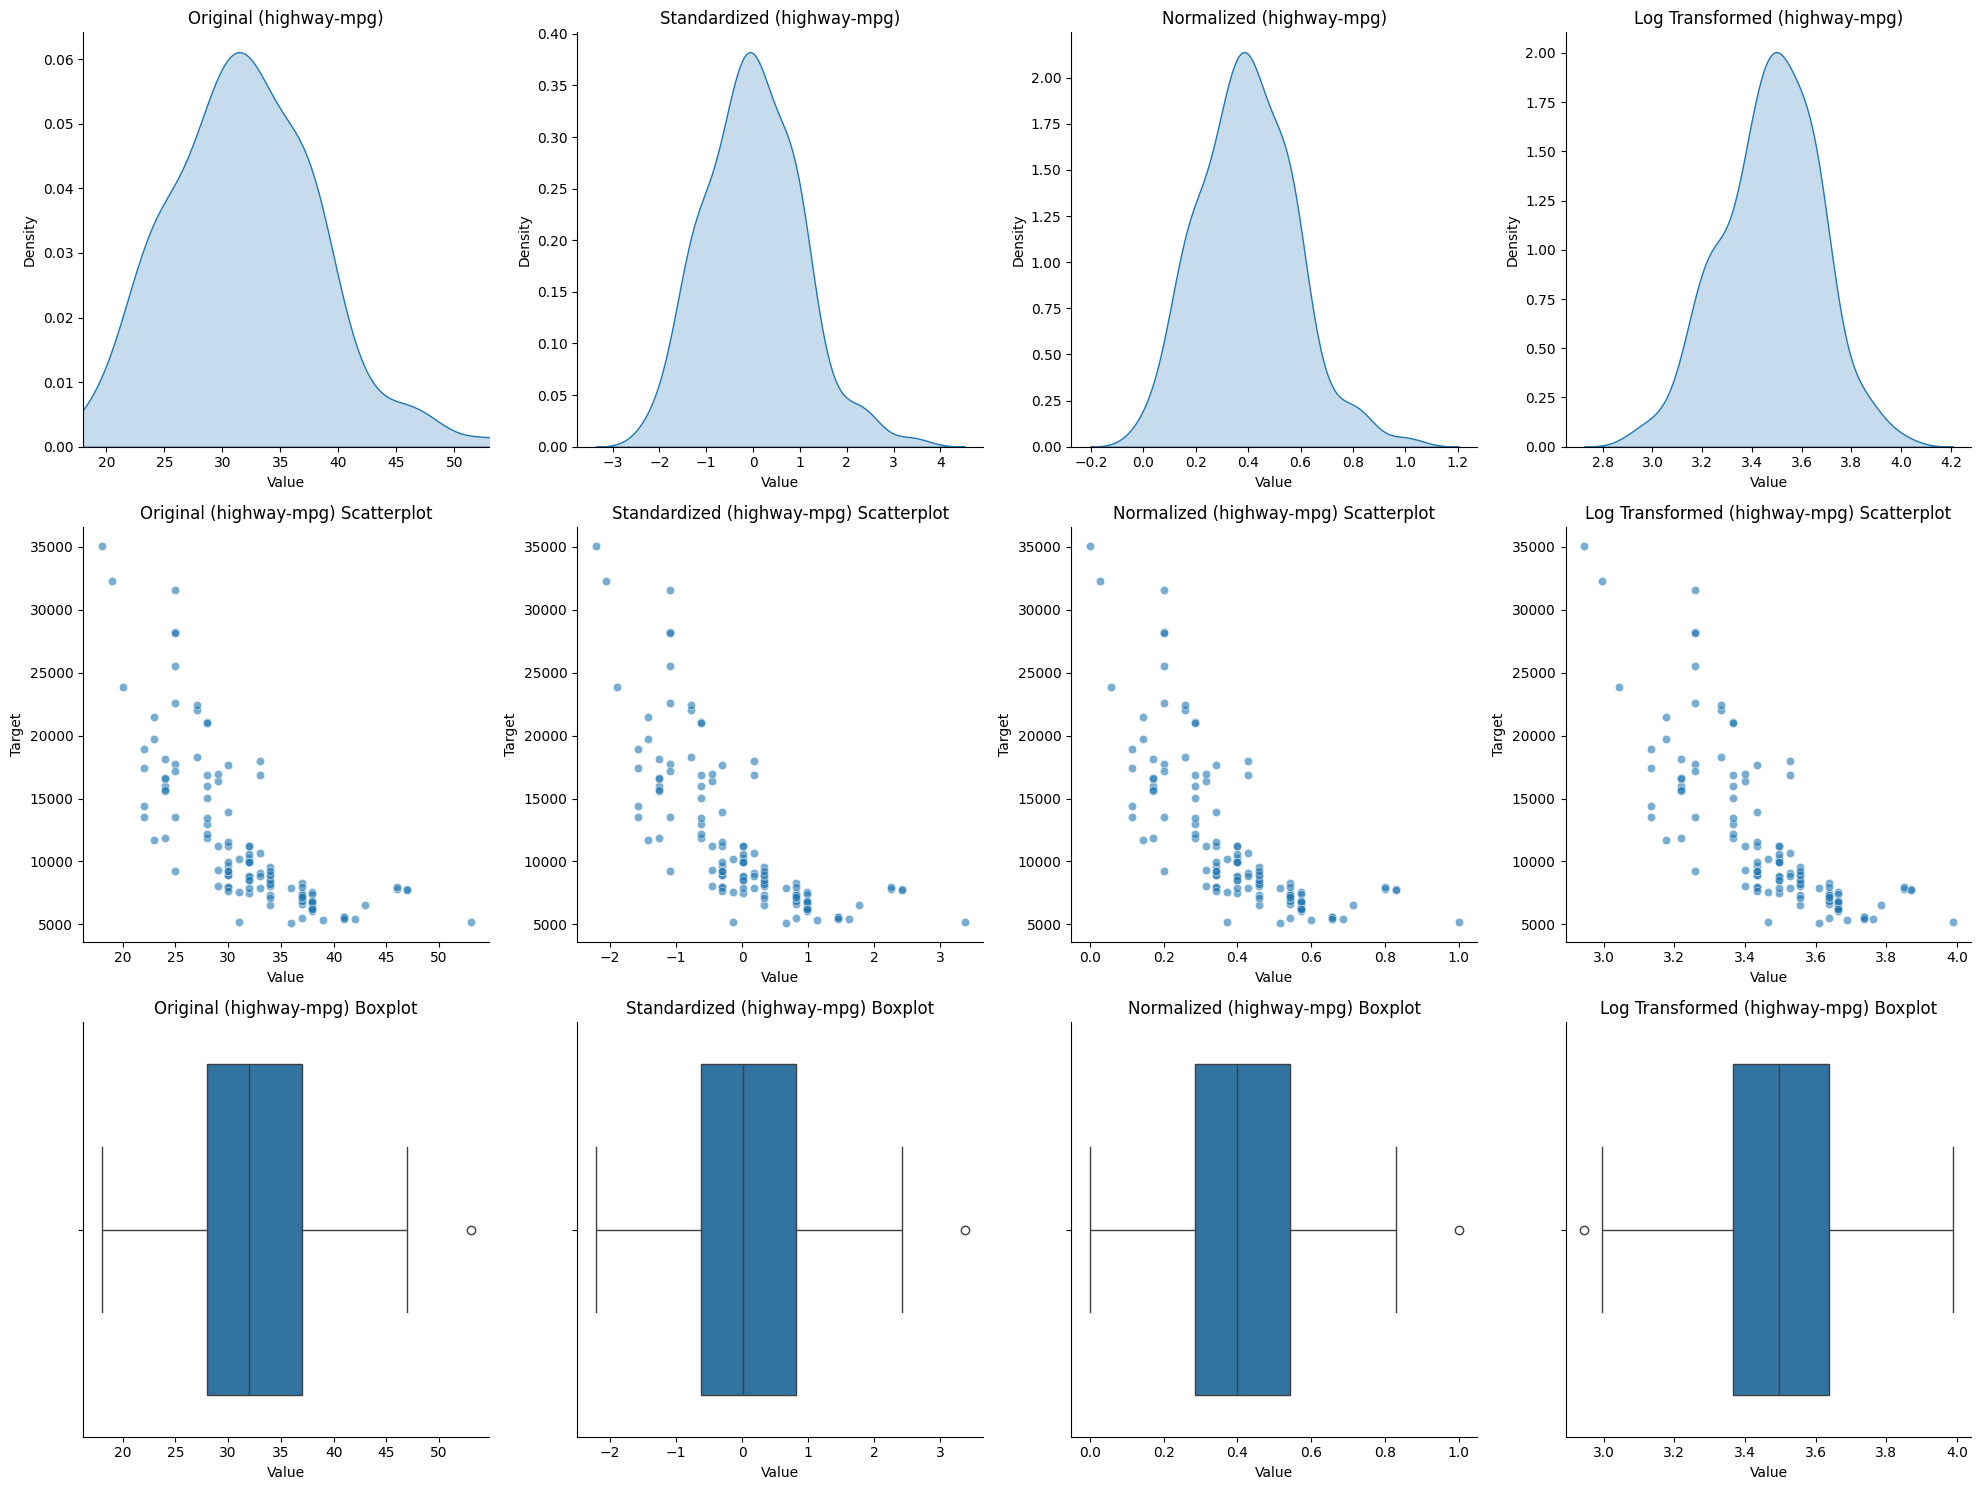

In [4]:
for col in X_train.columns:
    transformed_data = {
        'Original': X_train[col],
        'Standardized': standardize(X_train[col]),
        'Normalized': normalize(X_train[col]),
        'Log Transformed': log_transform(X_train[col])
    }
    # Polynomial features need special handling to match the index
    poly_transformed = polynomial_features(X_train[col])
    if len(poly_transformed) == len(X_train[col]):
        transformed_data['Polynomial (Degree 2)'] = poly_transformed

    # Plot transformations side by side with density plots, scatterplots, and boxplots
    fig, axes = plt.subplots(3, len(transformed_data), figsize=(20, 15))
    for i, (key, transformed) in enumerate(transformed_data.items()):
        # Density plot (top row)
        sns.kdeplot(transformed, fill=True, ax=axes[0, i])
        axes[0, i].set_title(f"{key} ({col})")
        axes[0, i].set_xlabel('Value')
        if key == 'Original':
            axes[0, i].set_xlim(X_train[col].min(), X_train[col].max())
            axes[0, i].set_ylim(0, None)  # Let KDE plot determine appropriate y-axis for the original
        else:
            axes[0, i].autoscale()  # Let each transformed plot determine its own appropriate axis scales

        # Scatterplot (middle row)
        sns.scatterplot(x=transformed, y=y_train, ax=axes[1, i], alpha=0.6)
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Target')
        axes[1, i].set_title(f"{key} ({col}) Scatterplot")

        # Boxplot (bottom row)
        sns.boxplot(x=transformed, ax=axes[2, i])
        axes[2, i].set_title(f"{key} ({col}) Boxplot")
        axes[2, i].set_xlabel('Value')
    plt.tight_layout()
    sns.despine()
    plt.show()


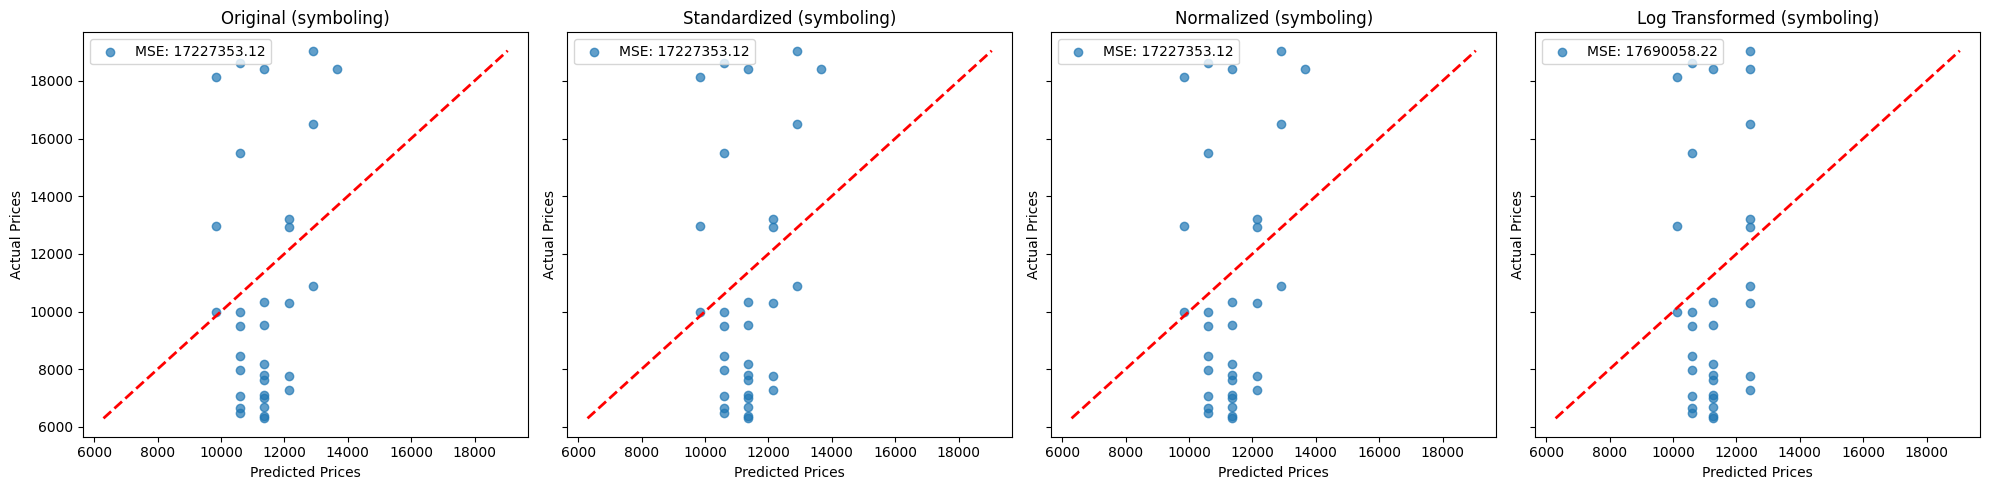

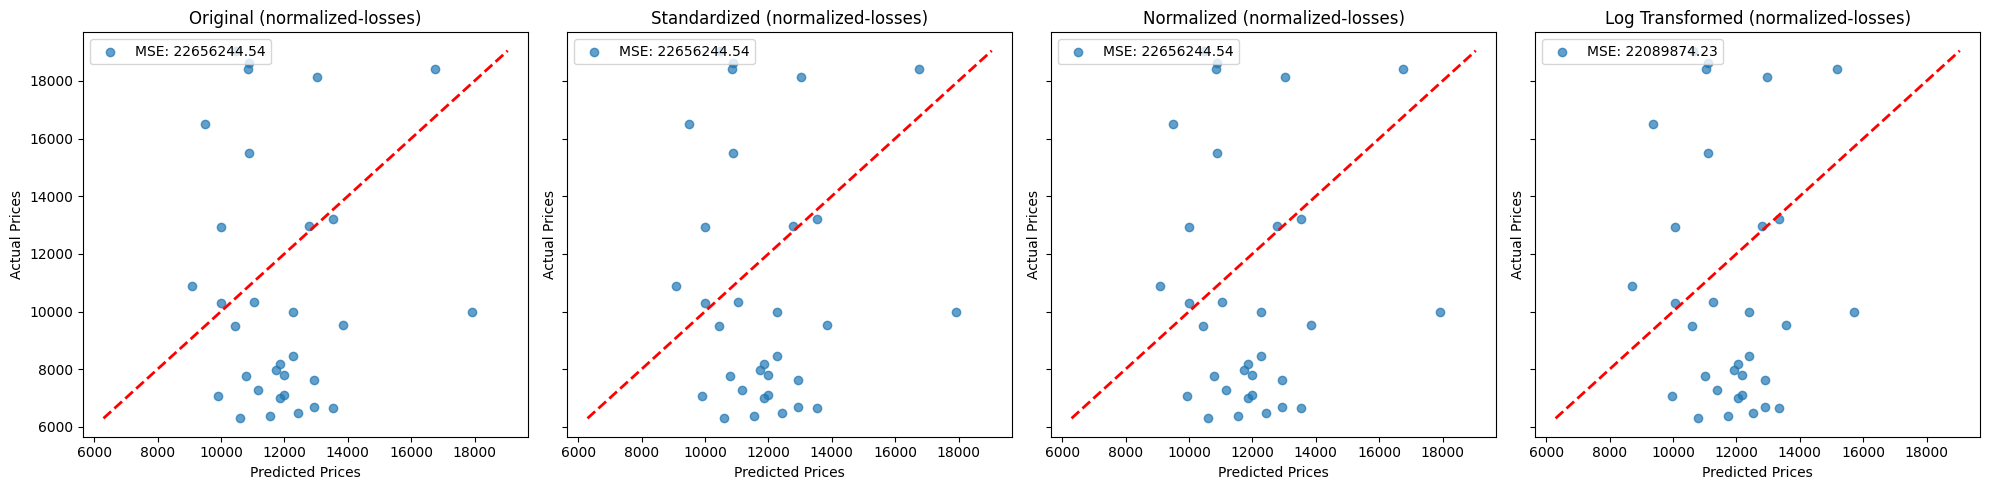

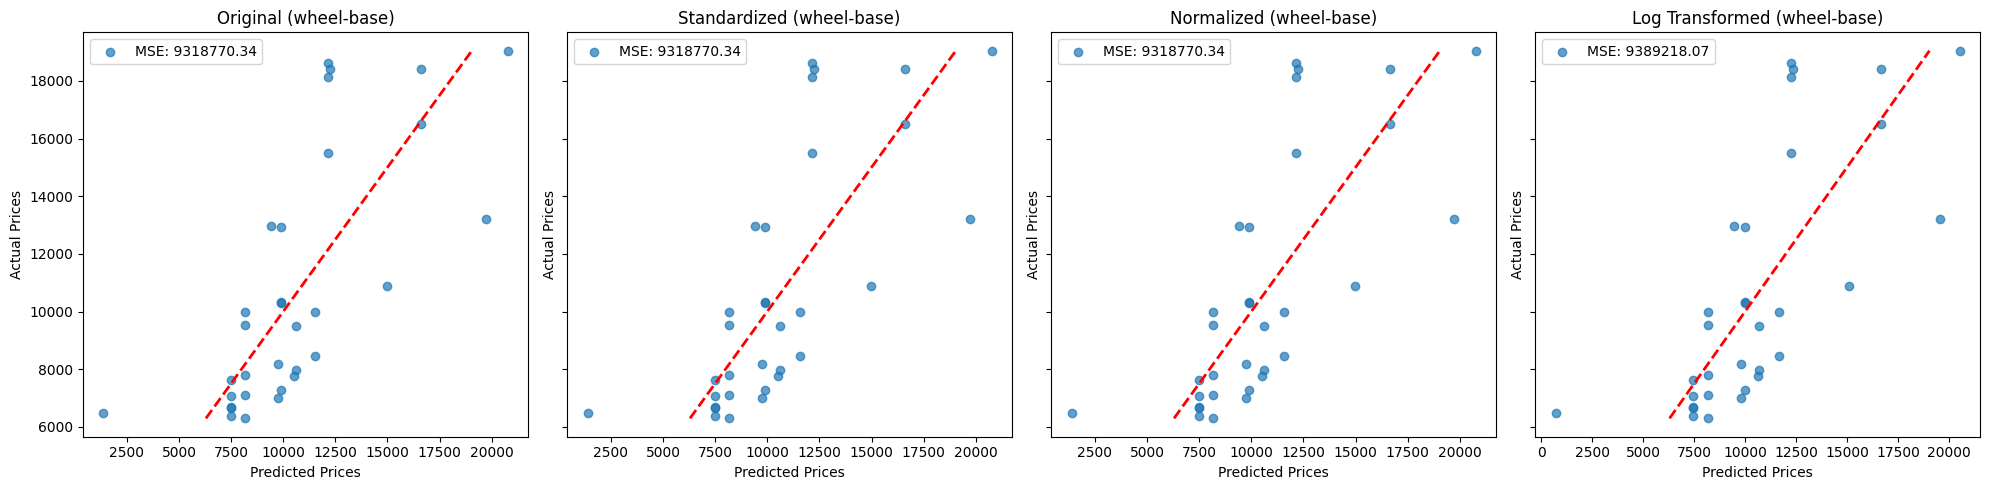

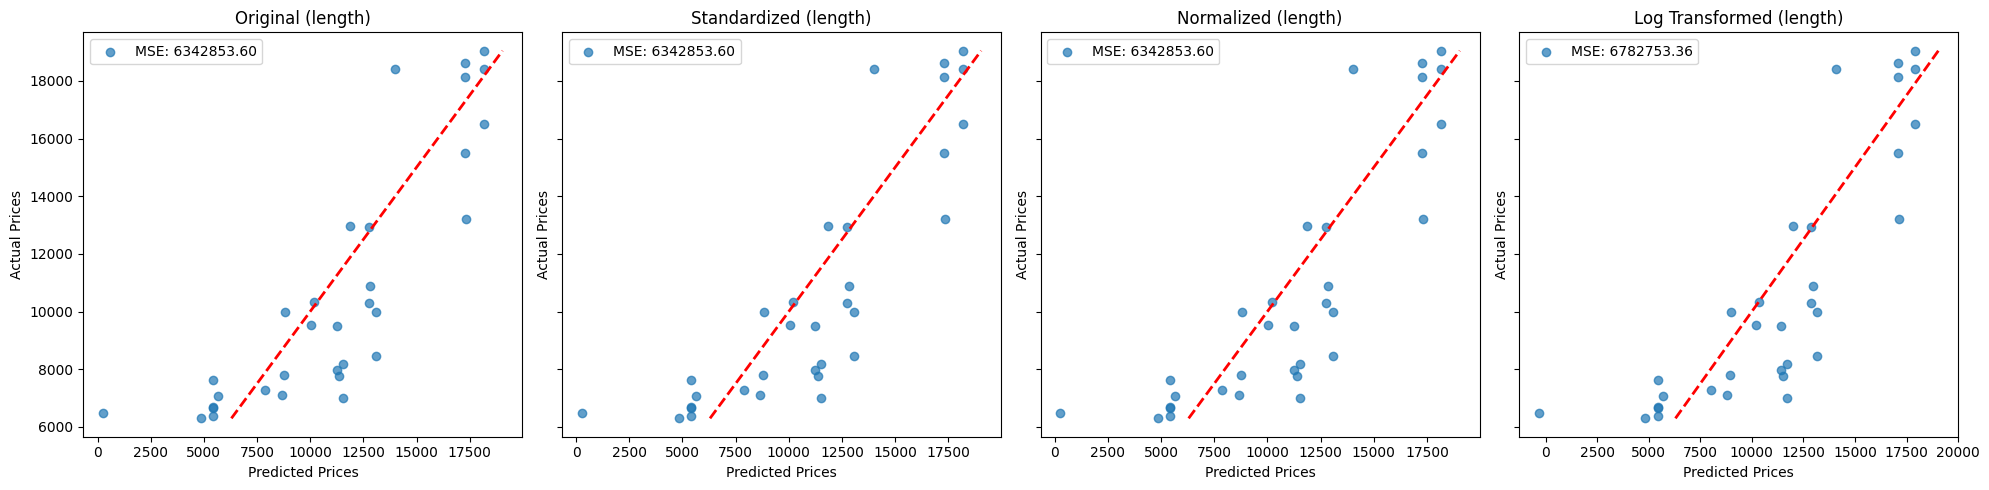

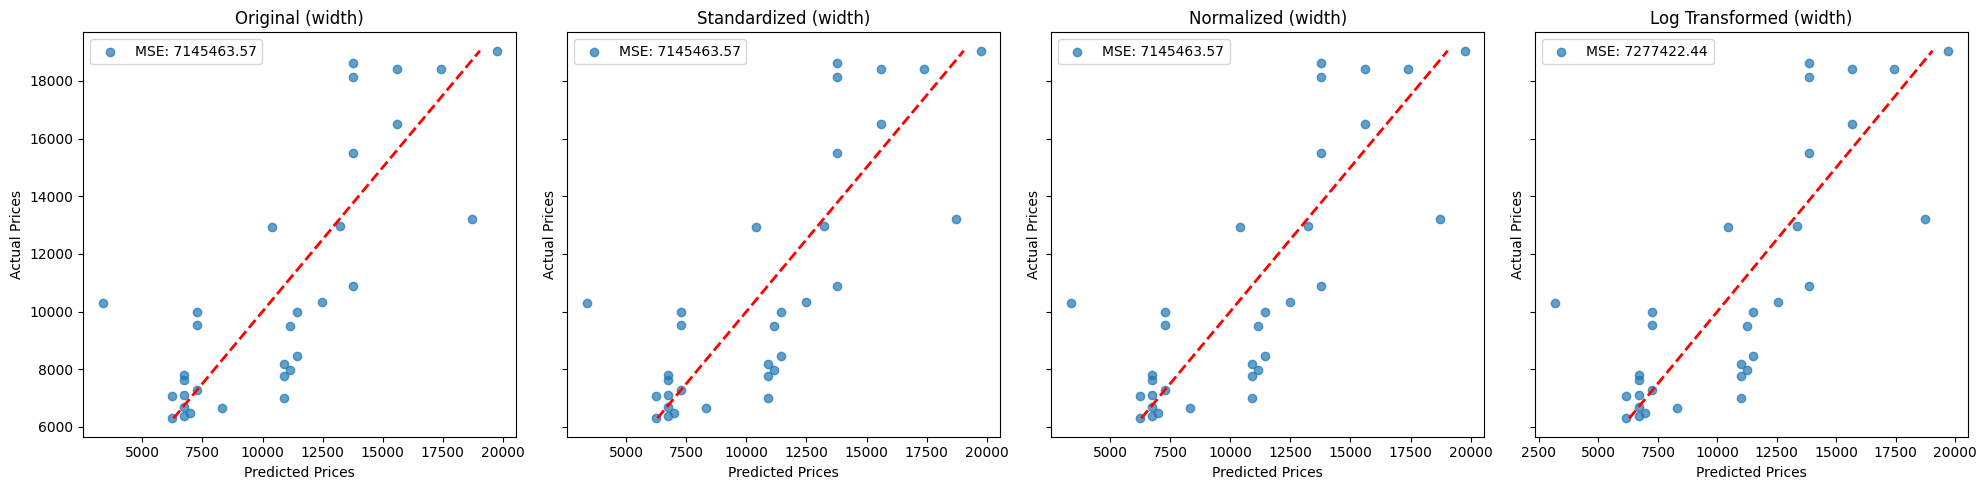

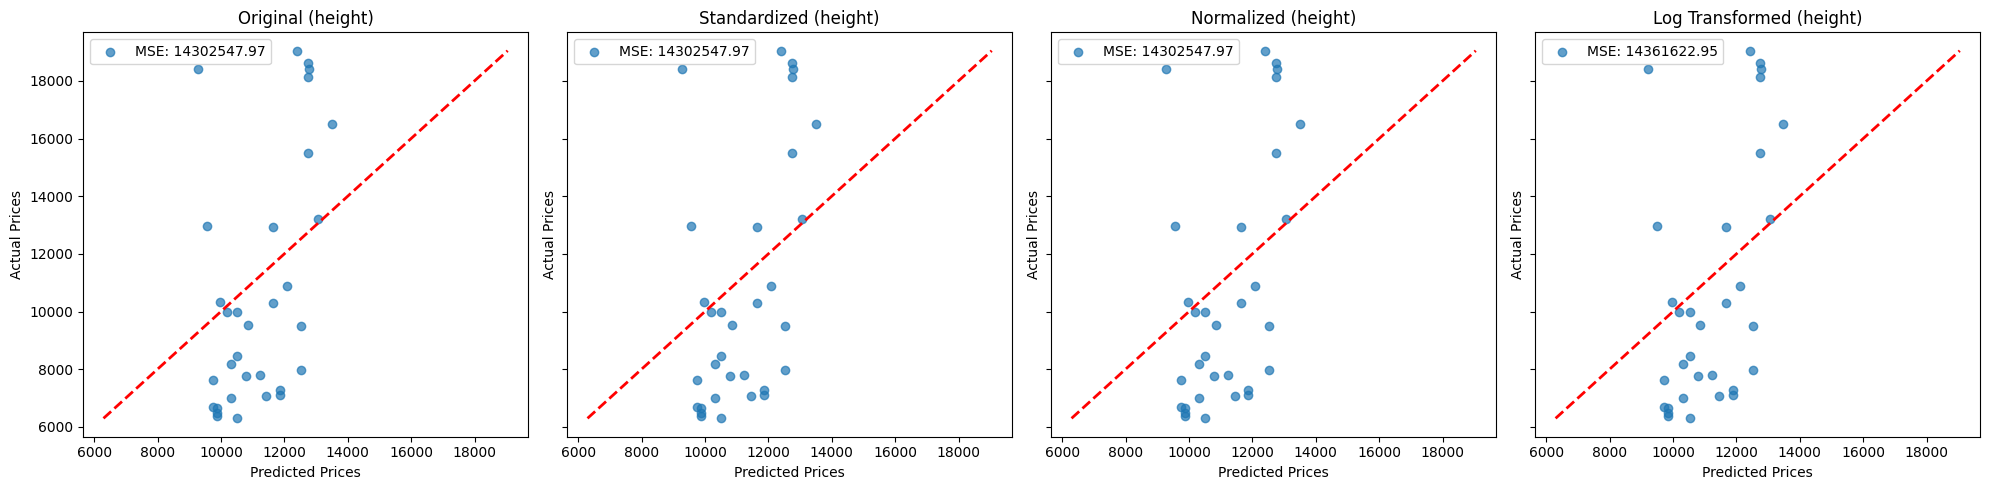

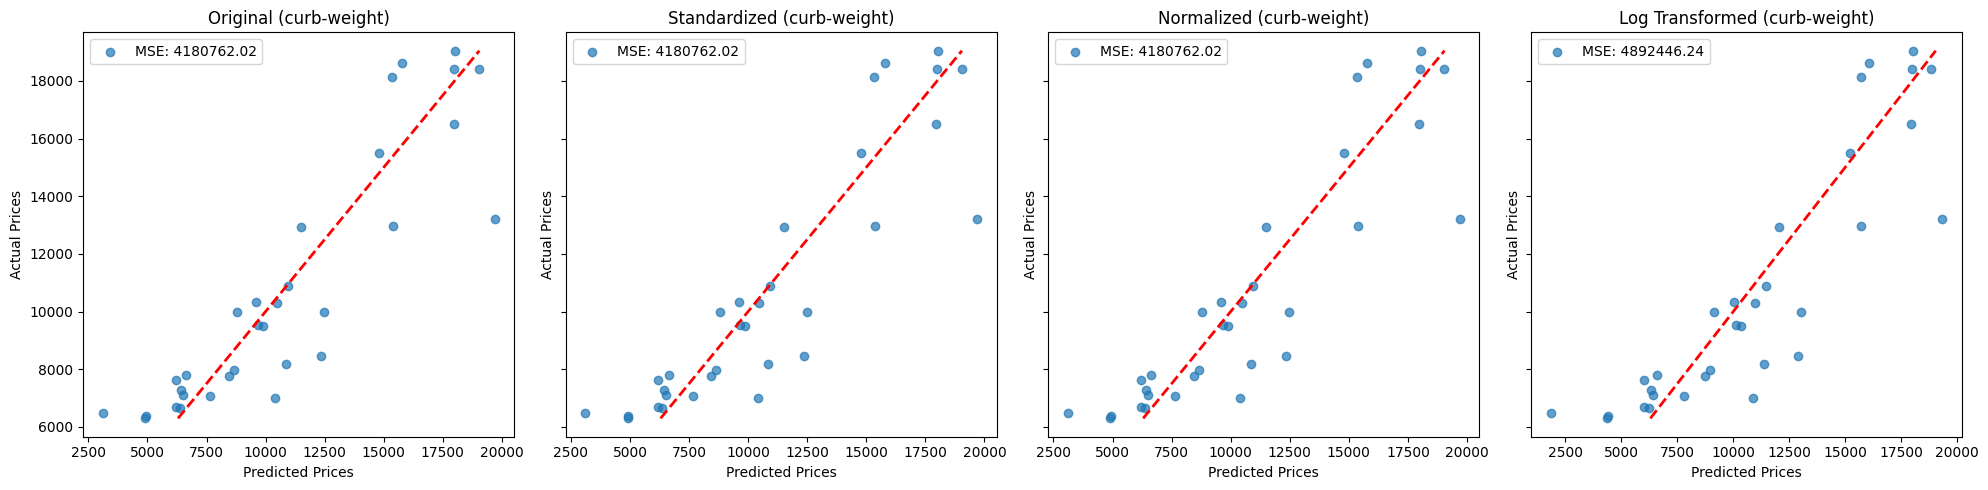

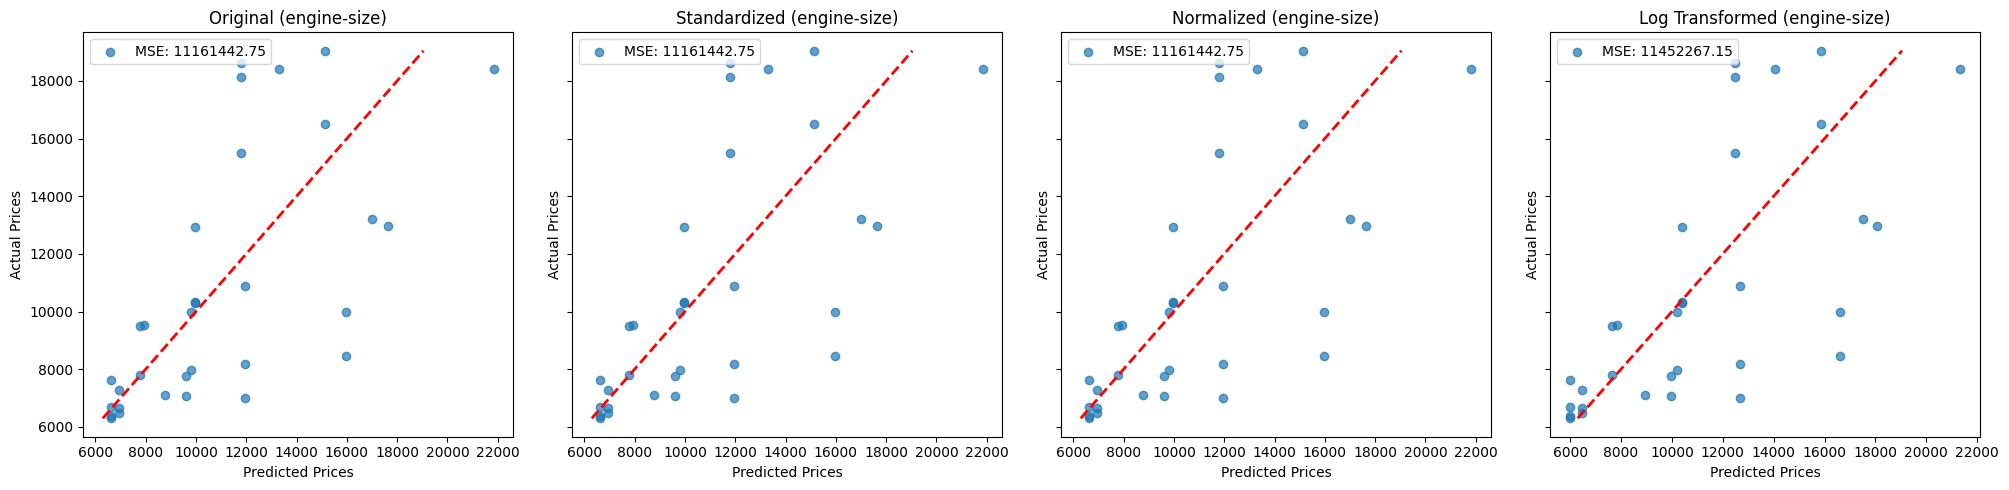

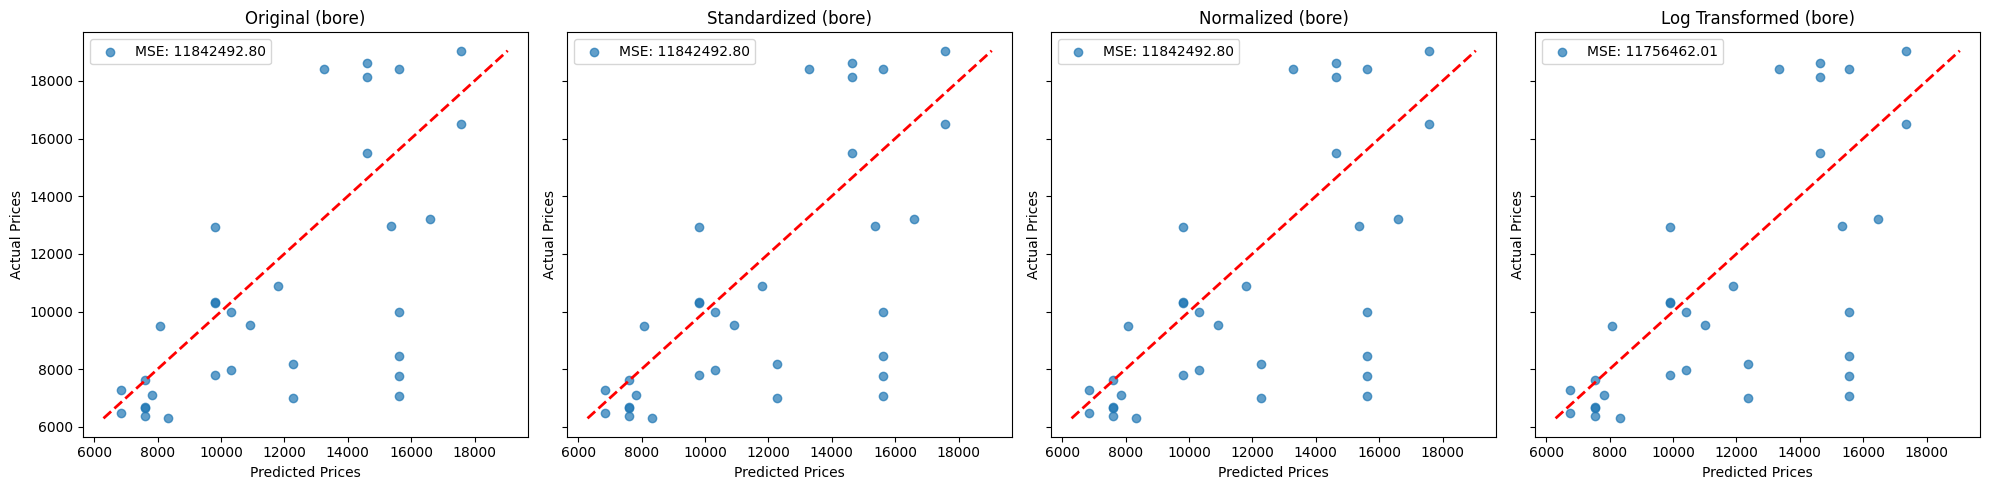

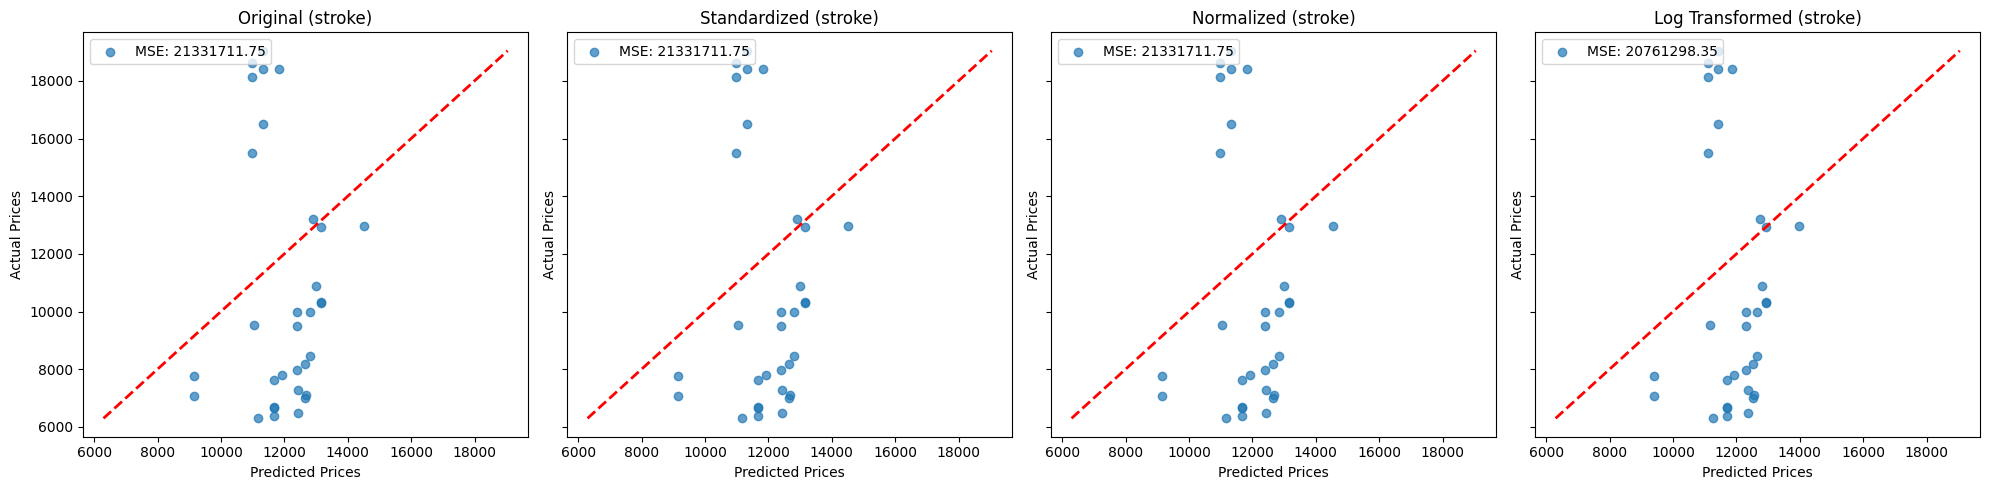

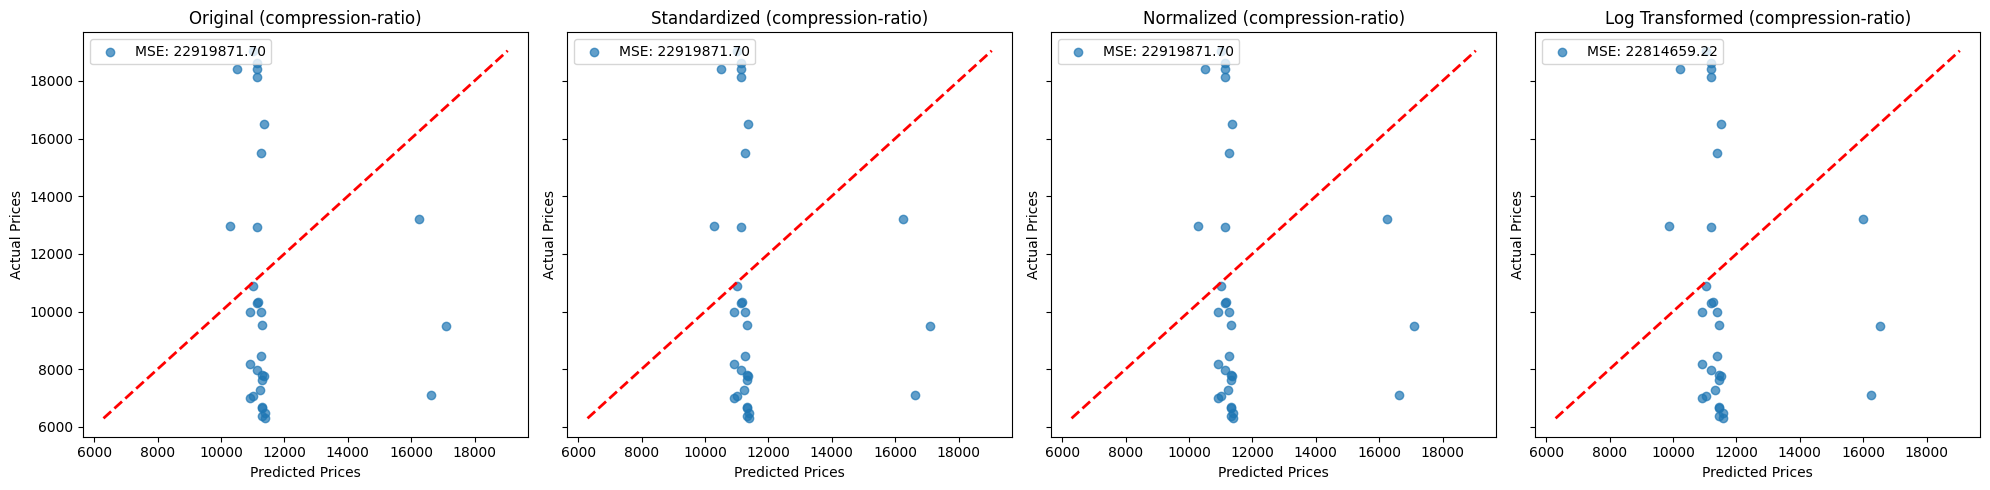

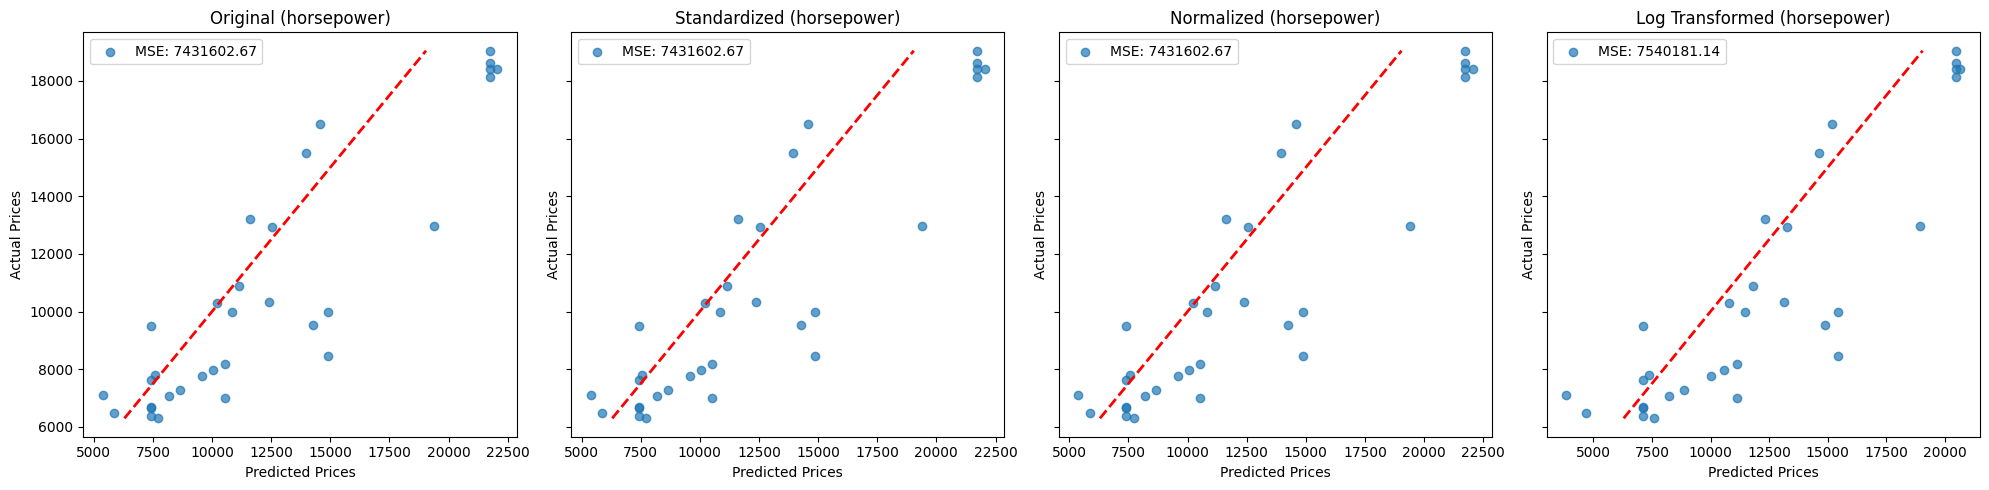

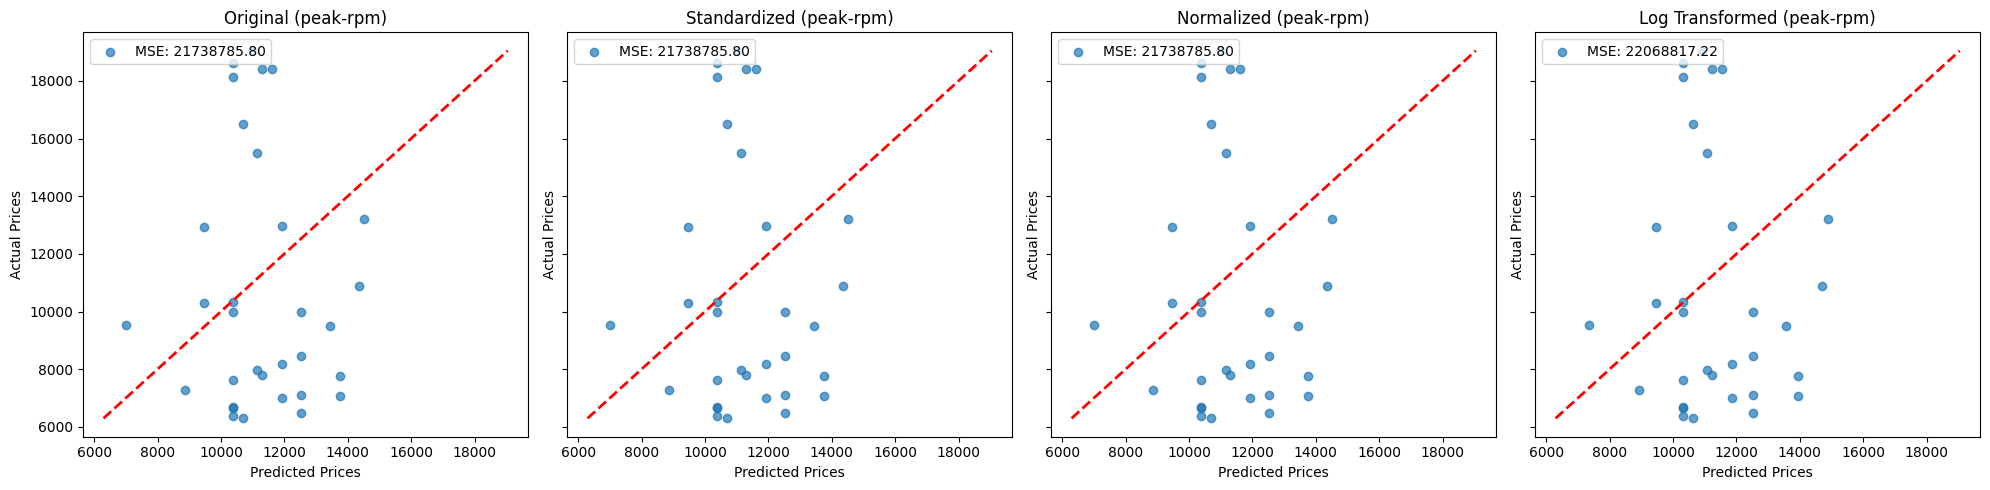

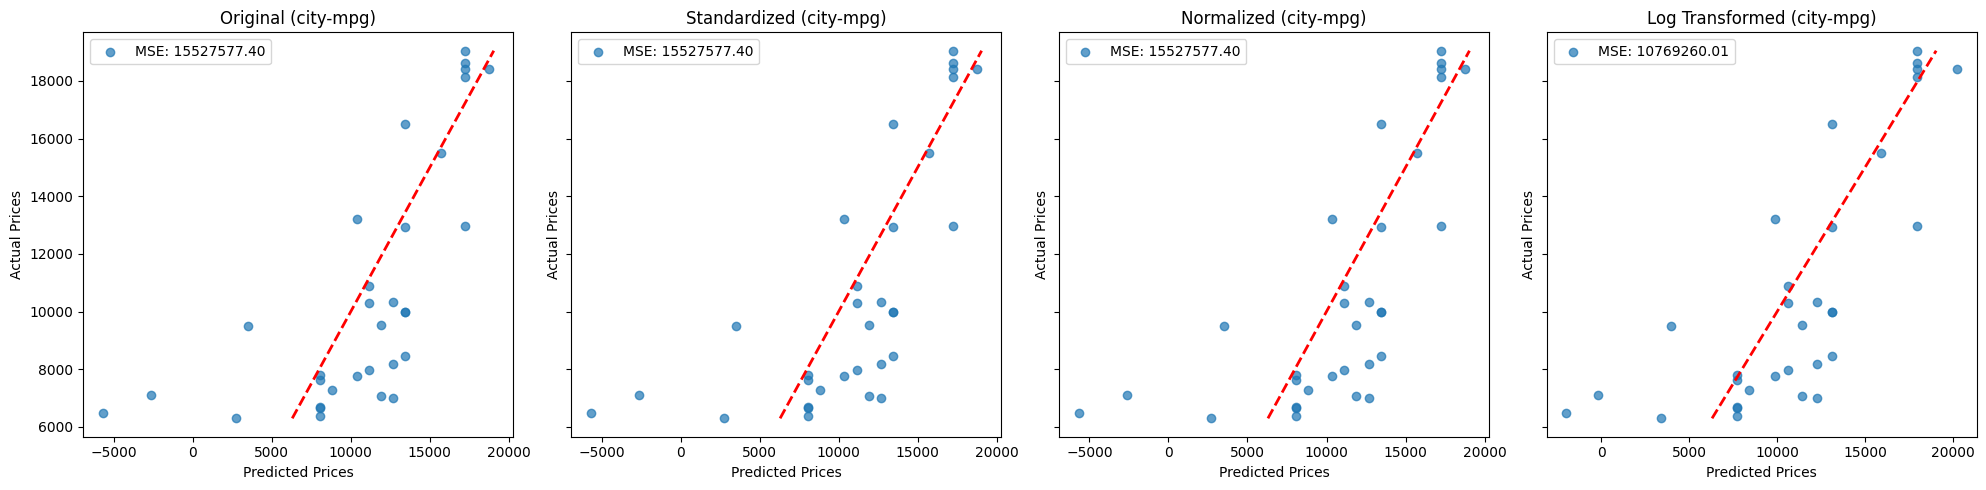

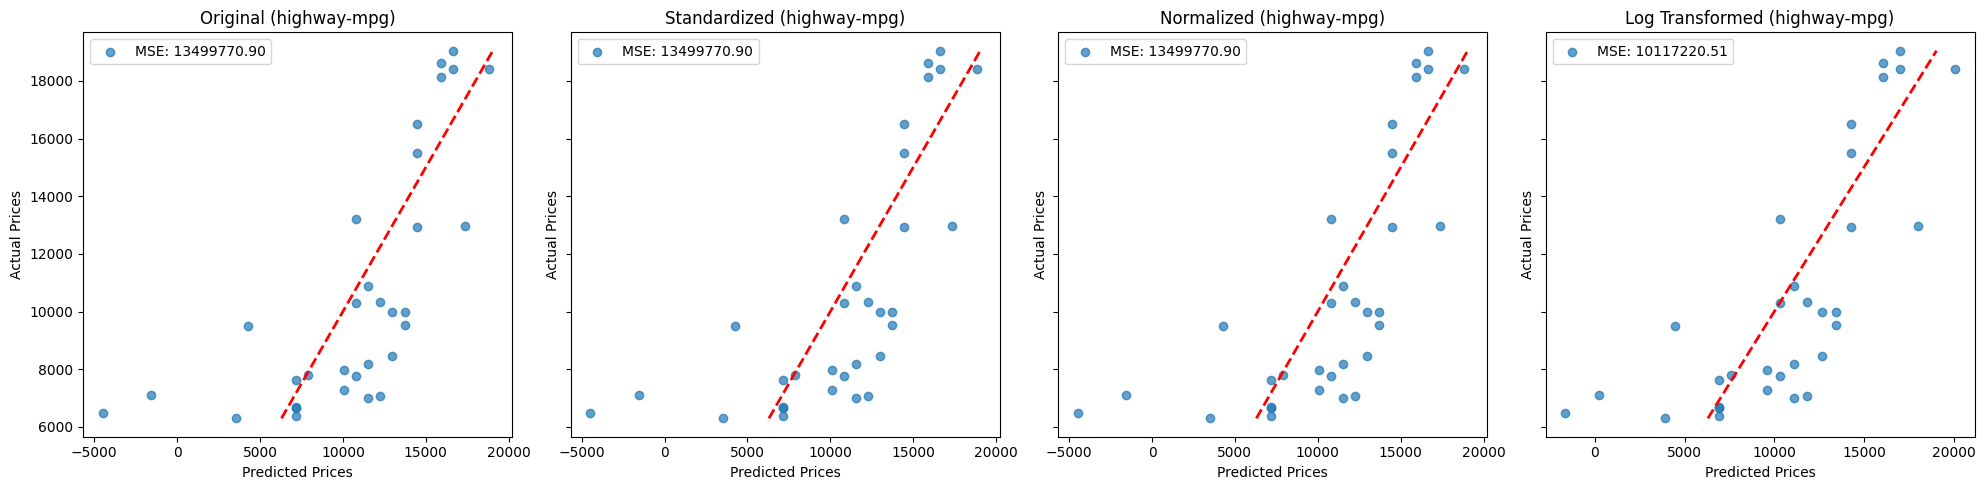

In [16]:
from sklearn.metrics import mean_squared_error

for col in X.columns:
    # Apply transformations to the entire dataset
    transformed_data = {
        'Original': pd.Series(X[col], index=X.index),
        'Standardized': pd.Series(standardize(X[col]), index=X.index),
        'Normalized': pd.Series(normalize(X[col]), index=X.index),
        'Log Transformed': pd.Series(log_transform(X[col]), index=X.index)
    }
    # Polynomial features need special handling to match the index
    poly_transformed = polynomial_features(X[col])
    if len(poly_transformed) == len(X[col]):
        transformed_data['Polynomial (Degree 2)'] = pd.Series(poly_transformed, index=X.index)

    # Initialize figure for side-by-side plots
    fig, axes = plt.subplots(1, len(transformed_data), figsize=(20, 5), sharey=True)

    for ax, (key, transformed) in zip(axes, transformed_data.items()):
        # Split the transformed data into train and test sets
        X_transformed_train = sm.add_constant(pd.DataFrame(transformed.loc[X_train.index], columns=[col], index=X_train.index))
        X_transformed_test = sm.add_constant(pd.DataFrame(transformed.loc[X_test.index], columns=[col], index=X_test.index))

        # Train OLS model
        model = sm.OLS(y_train, X_transformed_train).fit()
        
        # Predictions
        pred_test = model.predict(X_transformed_test)
        
        # Calculate MSE
        mse = mean_squared_error(y_test, pred_test)

        # Plot Predicted vs. Actual
        ax.scatter(pred_test, y_test, alpha=0.7, label=f"MSE: {mse:.2f}")
        ax.plot(
            [y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            color='red', linestyle='--', linewidth=2
        )
        ax.set_xlabel("Predicted Prices")
        ax.set_ylabel("Actual Prices")
        ax.set_title(f"{key} ({col})")
        ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
